In [1]:
# Built-in
import os
import math
import itertools
import multiprocessing

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import manifold

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

In [4]:
adata = sc.read( os.path.join(settings.data_path, "post-wt-clustering.h5ad"))
adata

AnnData object with n_obs × n_vars = 299193 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

Many of these images are "inspired" by https://www.sciencedirect.com/science/article/pii/S0896627323008449?via%3Dihub

FIgure 1 - lots of cluster expression

# Find cluster markers 
Yaman did this is 02_clustering but its no longer stored in adata.obs? It is in `figures/scanpy_cellranger_fixed_sex/top_markers_from_highly_variable.xlsx` tho

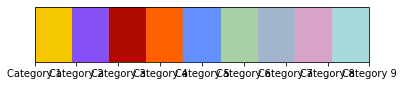

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the color list
colors = [
    "#F4C700",  # Yellow
    "#8650F5",  # Purple
    "#B00B00",  # Red
    "#FE6100",  # Orange
    "#648FFF",  # Blue
    "#A9CFA4",  # Pastel Green
    "#A3B5CC",  # Pastel Dark Blue
    "#D8A4C7",   # Pastel Magenta
    "#A8DADC"
]
# Create a ListedColormap
custom_cmap = ListedColormap(colors)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(6, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 8.0 for i in range(len(colors))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors))])

# Display the colorbar
plt.show()

In [6]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']
# cluster_colors = ['#8650F5','#A9CFA4','#8650F5','#8650F5',
#                  '#A3B5CC','#8650F5','#D8A4C7','#F4C700','#B00B00',
#                  '#A8DADC','#FE6100','#648FFF']
cluster_colors = ['#7662A0','#A9CFA4','#8650F5','#4F19BE',
                 '#A3B5CC','#BA98FF','#D8A4C7','#F4C700','#B00B00',
                 '#A8DADC','#FE6100','#648FFF']

In [7]:
adata = adata[(adata.obs['leiden'].isin(clusters))].copy()
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

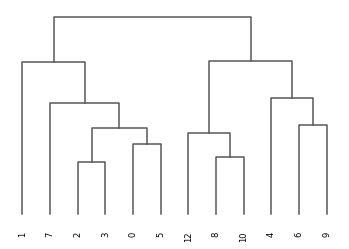

CPU times: user 375 ms, sys: 108 ms, total: 483 ms
Wall time: 456 ms


In [8]:
%%time
sc.tl.dendrogram(adata, 'leiden')
sc.pl.dendrogram(adata, 'leiden')

dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [9]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = np.array(cluster_colors)[cluster_lookup.index.tolist()]
cluster_lookup

id              name    color
1    1             L6-CT  #A9CFA4
7    7             L5-PT  #F4C700
2    2           L4/5-IT  #8650F5
3    3             L4-IT  #4F19BE
0    0           L2/3-IT  #7662A0
5    5           L5/6-IT  #BA98FF
11  12           CIN-VIP  #648FFF
8    8            CIN-PV  #B00B00
10  10           CIN-SST  #FE6100
4    4  Oligodendrocytes  #A3B5CC
6    6        Astrocytes  #D8A4C7
9    9               OPC  #A8DADC

In [10]:
adata.uns['name_colors'] = cluster_lookup['color'].tolist()

In [11]:
if 'id' not in adata.obs.columns:
    adata.obs = ( adata.obs.reset_index()
             .merge(cluster_lookup, left_on='leiden', right_on='id', how='left')
             .set_index('index') )

In [16]:
%%time
# Find marker genes 
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon',
                       groups=cluster_lookup['id'].to_list())

CPU times: user 31min 4s, sys: 3min 45s, total: 34min 49s
Wall time: 34min 27s


In [17]:
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [14]:
adata.write_h5ad('post-wt-clustering-with-markers.h5ad')

In [15]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [18]:
NUM_CLUSTER_MARKERS = 3

markers = sc.get.rank_genes_groups_df(adata, group=None, log2fc_min=0.0)
markers = markers.rename(columns={'group':'leiden'})
markers = markers.sort_values('scores', ascending=False)
markers = markers.groupby('leiden').head(NUM_CLUSTER_MARKERS).reset_index(drop=True) # I hate this line

# cluster_order_marker_gene_list = markers[['leiden','names']].copy()
# cluster_order_marker_gene_list['leiden'] = pd.Categorical(top_marker_gene_df['leiden'], categories=clusters, ordered=True)
# cluster_order_marker_gene_list = cluster_order_marker_gene_list.sort_values('leiden')['names'].to_list()

dendro_order_marker_gene_list = markers[['leiden','names']].copy()
dendro_order_marker_gene_list['leiden'] = pd.Categorical(dendro_order_marker_gene_list['leiden'], categories=dendro_ordered_cluster_ids, ordered=True)
dendro_order_marker_gene_list = dendro_order_marker_gene_list.sort_values('leiden')['names'].to_list()

marker_index_groups = [(NUM_CLUSTER_MARKERS*i, NUM_CLUSTER_MARKERS*i+NUM_CLUSTER_MARKERS-1) 
                       for i in range(len(clusters))]

In [19]:
# pladata = sc.pp.subsample(adata, fraction=0.1, copy=True)
# pladata

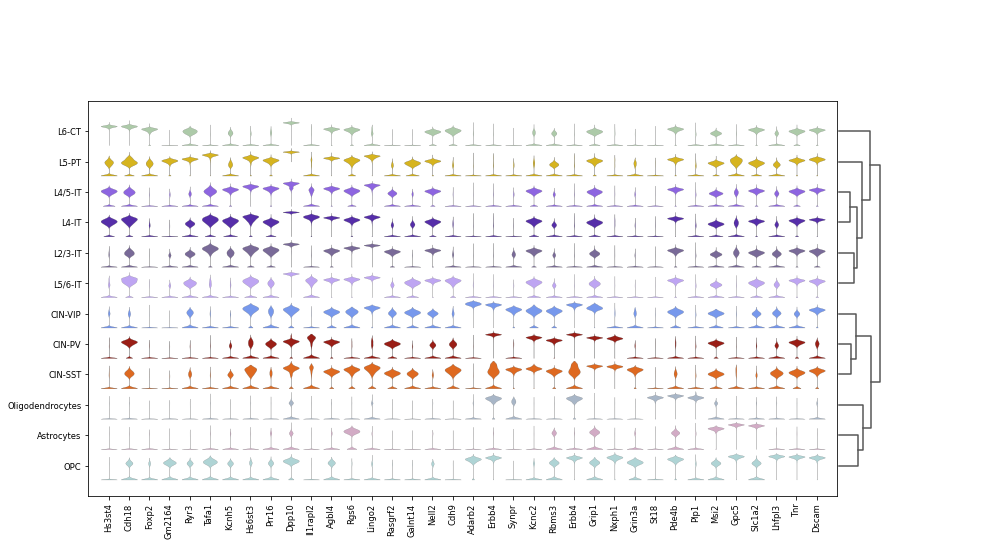

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
sc.pl.stacked_violin(adata, dendro_order_marker_gene_list, groupby='name', 
                     ax=ax,
                     dendrogram=True,
                     row_palette=sns.color_palette(adata.uns['name_colors']))
fig.savefig(os.path.join(settings.fig_path, 'cluster_marker_violin_grid.png'), transparent=False)
fig.savefig(os.path.join(settings.fig_path, 'vectors', 'cluster_marker_violin_grid.pdf'), transparent=False)

# Purple Yellow marker genes and cells (grouped by cluster) heatmap

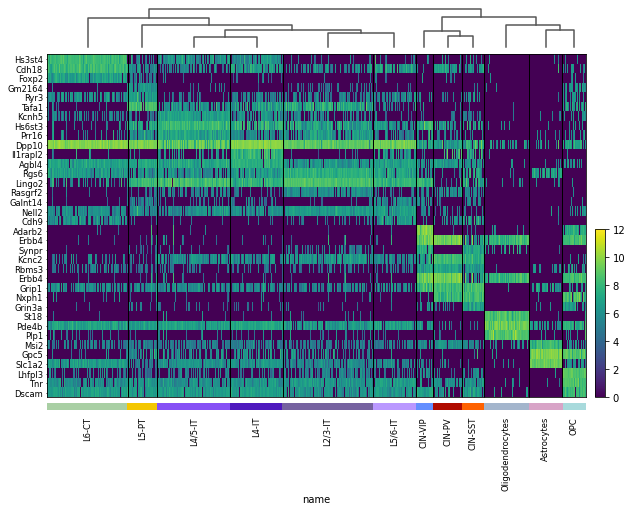

In [21]:
# colors rely on adata.uns[groupby + '_colors']
with plt.rc_context({'figure.figsize': (16,9)}):
    sc.pl.heatmap(adata, var_names=dendro_order_marker_gene_list, groupby='name', swap_axes=True,
                 dendrogram=True, show = False, cmap='viridis')
    plt.savefig(os.path.join(settings.fig_path, "cluster_marker_heatmap.png"), dpi=600, transparent=False)
    plt.savefig(os.path.join(settings.fig_path, 'vectors', "cluster_marker_heatmap.pdf"), transparent=False)

# PCA of <drug,time,cluster>
This can use the full dataset because PCA normalizes

Or do we need the downsampled one because of pseudobulking? Lets try it

In [17]:
bulk_categories = ['drug','time','leiden']
adpb_data = ADPBulk(adata, bulk_categories, name_delim='-', group_delim='_', method='mean')
pseudobulk_matrix = adpb_data.fit_transform()
pseudobulk_matrix.head()

Aggregating Samples: 100%|██████████| 216/216 [00:13<00:00, 15.51it/s]


Xkr4    Gm1992   Gm19938       Rp1  Sox17  \
drug_Ket-leiden_0-time_1   6.468958  1.016947  1.453024  0.007306    0.0   
drug_Ket-leiden_0-time_2   6.496104  1.336054  1.335350  0.004337    0.0   
drug_Ket-leiden_0-time_4   6.416983  1.583817  1.246689  0.009873    0.0   
drug_Ket-leiden_0-time_24  6.521374  1.265804  1.377850  0.004945    0.0   
drug_Ket-leiden_0-time_72  6.568166  1.094565  1.552800  0.007559    0.0   

                            Gm37323    Lypla1     Tcea1     Rgs20   Gm16041  \
drug_Ket-leiden_0-time_1   0.000000  1.088739  2.492456  3.274968  0.010426   
drug_Ket-leiden_0-time_2   0.000000  0.963007  2.183534  3.163062  0.026552   
drug_Ket-leiden_0-time_4   0.001296  0.911333  2.229454  2.775670  0.026966   
drug_Ket-leiden_0-time_24  0.000000  1.121475  2.378843  2.671679  0.015799   
drug_Ket-leiden_0-time_72  0.000000  1.173018  2.516832  3.287724  0.010446   

                            Atp6v1h     Oprk1    Npbwr1    Rb1cc1  \
drug_Ket-leiden_0-time_1   4.113826  0.035613  0.001460  4.479383   
drug_Ket-leiden_0-time_2   3.871823  0.025641  0.000000  4.304516   
drug_Ket-leiden_0-time_4   3.772720  0.036751  0.002273  4.085085   
drug_Ket-leiden_0-time_24  3.907380  0.029059  0.001569  4.443132   
drug_Ket-leiden_0-time_72  4.128664  0.027435  0.000000  4.530826   

                           4732440D04Rik    Alkal1      St18    Pcmtd1  \
drug_Ket-leiden_0-time_1        0.742051  0.009244  0.291466  4.307073   
drug_Ket-leiden_0-time_2        0.696615  0.018469  0.326586  4.043207   
drug_Ket-leiden_0-time_4        0.868639  0.009297  0.189232  3.895566   
drug_Ket-leiden_0-time_24       0.734230  0.017637  0.287773  3.962719   
drug_Ket-leiden_0-time_72       0.815663  0.013652  0.220429  4.197905   

                            Gm26901   Gm30414  ...       Uty     Ddx3y  \
drug_Ket-leiden_0-time_1   1.179329  0.008013  ...  1.715139  0.713294   
drug_Ket-leiden_0-time_2   1.337253  0.009876  ...  2.108970  0.789439   
drug_Ket-leiden_0-time_4   1.238438  0.015028  ...  1.953763  0.746799   
drug_Ket-leiden_0-time_24  1.488606  0.015449  ...  1.824039  0.822767   
drug_Ket-leiden_0-time_72  1.473754  0.021287  ...  1.531779  0.535068   

                              Usp9y   Gm21693   Gm21294   Gm21860   Gm47283  \
drug_Ket-leiden_0-time_1   0.005529  0.000000  0.000000  0.211514  4.931722   
drug_Ket-leiden_0-time_2   0.007842  0.002151  0.000000  0.140964  4.822601   
drug_Ket-leiden_0-time_4   0.008038  0.000000  0.001159  0.150758  4.552855   
drug_Ket-leiden_0-time_24  0.006311  0.000000  0.000000  0.237304  5.105566   
drug_Ket-leiden_0-time_72  0.008014  0.001862  0.000000  0.337954  5.536595   

                           AC125149.3  AC133103.1  CAAA01118383.1  AC132444.5  \
drug_Ket-leiden_0-time_1     0.000000    0.001125        0.345711    0.000000   
drug_Ket-leiden_0-time_2     0.000000    0.000997        0.311085    0.002266   
drug_Ket-leiden_0-time_4     0.000000    0.000000        0.272670    0.001163   
drug_Ket-leiden_0-time_24    0.000000    0.003670        0.283524    0.000000   
drug_Ket-leiden_0-time_72    0.001414    0.001860        0.365436    0.000000   

                           AC132444.6     Vamp7     Spry3     Tmlhe  \
drug_Ket-leiden_0-time_1     0.001327  0.465741  0.036974  1.127894   
drug_Ket-leiden_0-time_2     0.004168  0.352157  0.028913  0.932250   
drug_Ket-leiden_0-time_4     0.002170  0.327125  0.014178  0.883551   
drug_Ket-leiden_0-time_24    0.003749  0.321901  0.018595  1.027152   
drug_Ket-leiden_0-time_72    0.003180  0.419692  0.041362  1.110962   

                           4933409K07Rik   Gm10931  CT868723.1  \
drug_Ket-leiden_0-time_1        0.110382  0.152097    0.006431   
drug_Ket-leiden_0-time_2        0.096103  0.124199    0.004787   
drug_Ket-leiden_0-time_4        0.074683  0.100502    0.003305   
drug_Ket-leiden_0-time_24       0.111862  0.117404    0.003890   
drug_Ket-leiden_0-time_72       0.140028  0.125531    0.008559   

        

In [18]:
X = pseudobulk_matrix.to_numpy()
pca = PCA(n_components=2).fit(X)
pca.explained_variance_ratio_

array([0.5971157 , 0.09881963], dtype=float32)

In [19]:
pb_embeddings = pd.DataFrame(pca.transform(X), columns=['PCA_1', 'PCA_2'], index=pseudobulk_matrix.index)
pb_embeddings = pb_embeddings.join(adpb_data.get_meta().set_index('SampleName'))
pb_embeddings['leiden'] = pd.Categorical(pb_embeddings['leiden'], categories=dendro_ordered_cluster_ids, ordered=True)
pb_embeddings['drug'] = pd.Categorical(pb_embeddings['drug'], categories=drugs, ordered=True)
pb_embeddings = pb_embeddings.merge(cluster_lookup, how='inner', left_on='leiden', right_on='id')
pb_embeddings = pb_embeddings.sort_values('drug', ascending=False)
pb_embeddings.head()

PCA_1      PCA_2   drug leiden  time  id        name
40   18.443558  30.270229  Psilo     12     4  12     CIN-VIP
104 -66.000015  -9.277733  Psilo      7     1   7       L5-ET
97   99.789650  -9.965933  Psilo      6    72   6  Astrocytes
53  -32.145634 -15.927290  Psilo      2    72   2     L4/5-IT
52  -30.995667 -15.555490  Psilo      2    24   2     L4/5-IT

In [20]:
linear_time_lookup = {0:0, 1:1, 2:2, 4:3, 24:4, 72:5}
pb_embeddings['linear_time'] = pb_embeddings['time'].map(linear_time_lookup)
pb_embeddings.head()

PCA_1      PCA_2   drug leiden  time  id        name  linear_time
40   18.443558  30.270229  Psilo     12     4  12     CIN-VIP            3
104 -66.000015  -9.277733  Psilo      7     1   7       L5-ET            1
97   99.789650  -9.965933  Psilo      6    72   6  Astrocytes            5
53  -32.145634 -15.927290  Psilo      2    72   2     L4/5-IT            5
52  -30.995667 -15.555490  Psilo      2    24   2     L4/5-IT            4

- color = time
- glyph = cluster
- ? = drug

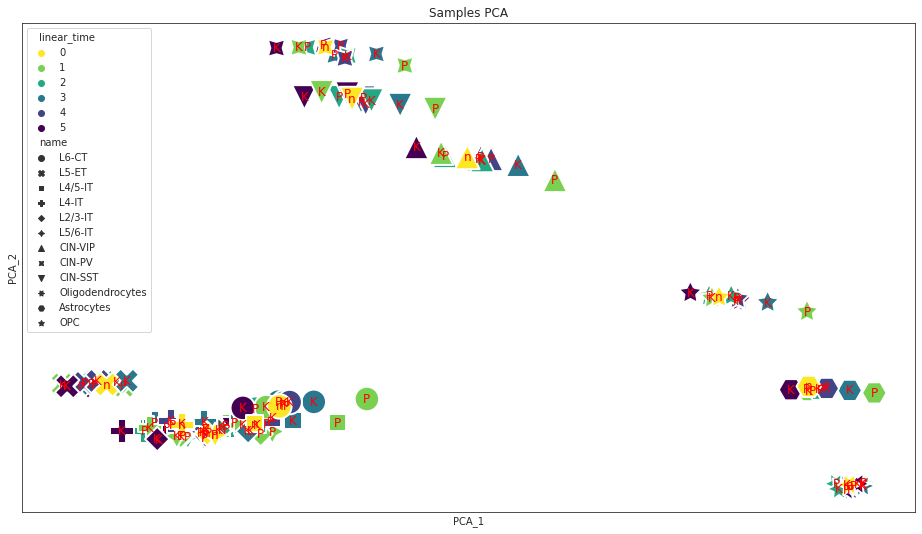

In [21]:
with plt.rc_context({'figure.figsize': (16,9)}):
    sns.set_style('white')
    sns.scatterplot(data=pb_embeddings,
                   x='PCA_1', y='PCA_2', 
                    style='name', hue='linear_time',
                    palette='viridis_r', s=600)
    for row in pb_embeddings.itertuples():
        plt.text(x=row.PCA_1, y=row.PCA_2,
                s=row.drug[:1], color='red', fontsize='large',
                horizontalalignment='center', verticalalignment='center')
    plt.title('Samples PCA')
    plt.xticks(ticks=[], labels=[])
    plt.yticks(ticks=[], labels=[])

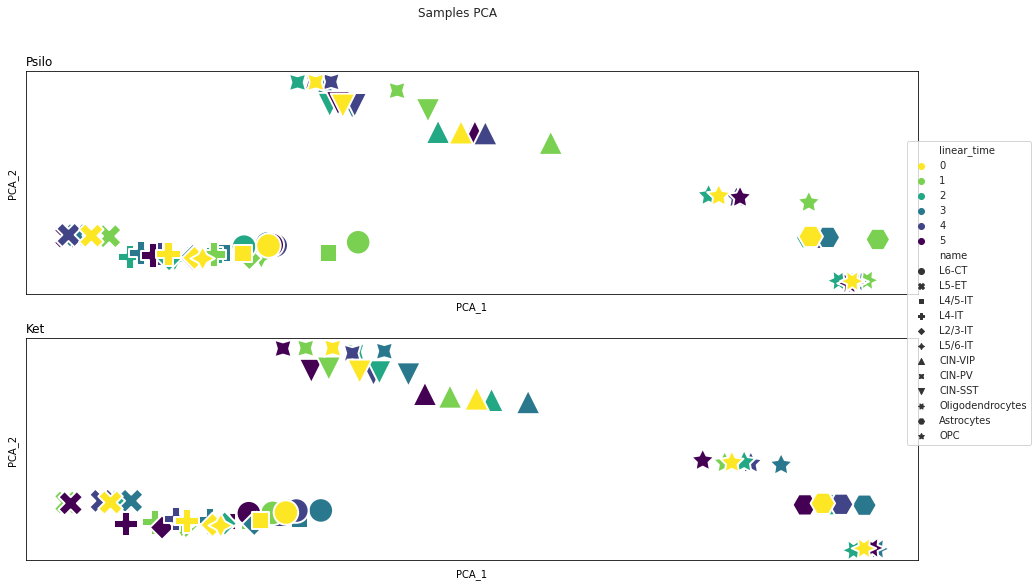

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.set_style('white')
sns.scatterplot(
    ax=axes[0], 
    data=pb_embeddings.query('drug=="none" | drug=="Psilo"'),
    x='PCA_1', y='PCA_2', 
    style='name', hue='linear_time',
    palette='viridis_r', s=600,
)
sns.scatterplot(
    ax=axes[1], 
    data=pb_embeddings.query('drug=="none" | drug=="Ket"'),
    x='PCA_1', y='PCA_2', 
    style='name', hue='linear_time',
    palette='viridis_r', s=600
)

handles, labels = axes[0].get_legend_handles_labels()

for ax,drug in zip(axes, ['Psilo','Ket']):
    ax.set_title(drug, loc='left')
    ax.get_legend().remove()
    ax.set_xticks(ticks=[], labels=[])
    ax.set_yticks(ticks=[], labels=[])
    
fig.legend(handles, labels, loc='right')
fig.suptitle('Samples PCA')
plt.show()

# PCA of <drug,time,cluster> but only for Ex
This can use the full dataset because PCA normalizes

In [23]:
excit_leidens = ["1","7","2","3","0","5"]

- color = time
- glyph = cluster
- ? = drug

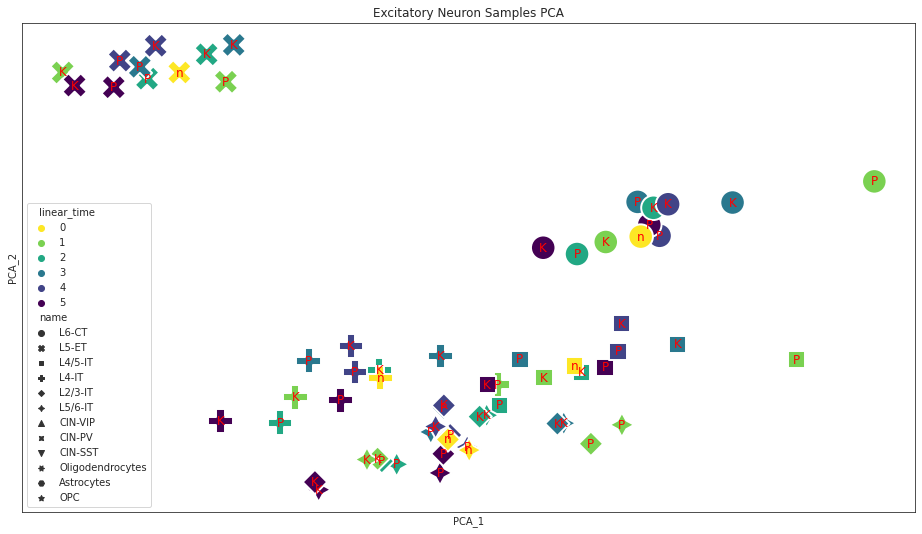

In [24]:
with plt.rc_context({'figure.figsize': (16,9)}):
    sns.set_style('white')
    sns.scatterplot(data=pb_embeddings[pb_embeddings.leiden.isin(excit_leidens)],
                   x='PCA_1', y='PCA_2', 
                    style='name', hue='linear_time',
                    palette='viridis_r', s=600,)
    for row in pb_embeddings[pb_embeddings.leiden.isin(excit_leidens)].itertuples():
        plt.text(x=row.PCA_1, y=row.PCA_2,
                s=row.drug[:1], color='red', fontsize='large',
                horizontalalignment='center', verticalalignment='center')
    plt.title('Excitatory Neuron Samples PCA')
    plt.xticks(ticks=[], labels=[])
    plt.yticks(ticks=[], labels=[])

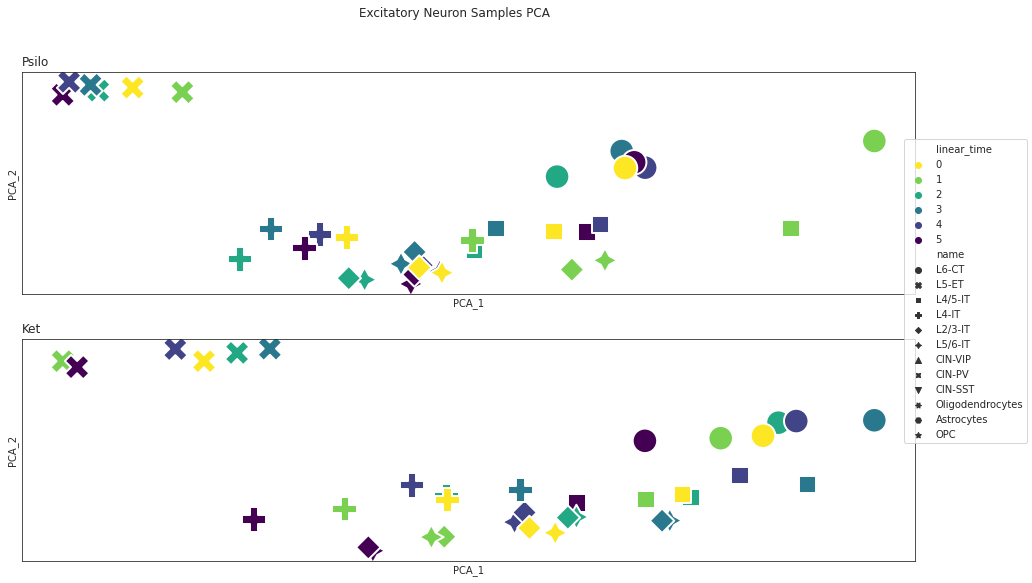

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.set_style('white')
sns.scatterplot(
    ax=axes[0], 
    data=pb_embeddings[pb_embeddings.leiden.isin(excit_leidens)].query('drug=="none" | drug=="Psilo"'),
    x='PCA_1', y='PCA_2', 
    style='name', hue='linear_time',
    palette='viridis_r', s=600,
)
sns.scatterplot(
    ax=axes[1], 
    data=pb_embeddings[pb_embeddings.leiden.isin(excit_leidens)].query('drug=="none" | drug=="Ket"'),
    x='PCA_1', y='PCA_2', 
    style='name', hue='linear_time',
    palette='viridis_r', s=600
)

handles, labels = axes[0].get_legend_handles_labels()

for ax,drug in zip(axes, ['Psilo','Ket']):
    ax.set_title(drug, loc='left')
    ax.get_legend().remove()
    ax.set_xticks(ticks=[], labels=[])
    ax.set_yticks(ticks=[], labels=[])
    
fig.legend(handles, labels, loc='right')
fig.suptitle('Excitatory Neuron Samples PCA')
plt.show()

Theres some constant movement to the left over time, specifically for ketamine. Could be useful to find the PCA loadings and see what genes are top hits for the negative PCA 1 axis

# Loadings of PCA 1
PCA 1 seems to drive a lot of within-cluster variance

In [26]:
pca1 = pca.components_[0]
pca1.shape

(24181,)

In [27]:
pca1[pca1 > 0].shape

(3701,)

In [28]:
top_loading_indices = np.flip(np.argsort(np.abs(pca1)))[:100]
[ print(gene, ',', loading) for gene,loading in
 zip(adata.var.index[top_loading_indices].to_list(), pca1[top_loading_indices].tolist()) ]
pass

Syt1 , -0.04843835160136223
Dlgap2 , -0.04715260490775108
Kcnip4 , -0.04692436382174492
Grin2a , -0.04641153663396835
Cntnap2 , -0.04562000185251236
Kcnh7 , -0.04535895586013794
Etl4 , -0.04403972625732422
Tenm2 , -0.043583739548921585
Grin2b , -0.042672477662563324
Snhg11 , -0.04221291095018387
Dpp10 , -0.042131610214710236
Frmpd4 , -0.042057283222675323
Chrm3 , -0.04175281524658203
Nrg1 , -0.04168576002120972
Kcnq5 , -0.04161481559276581
Pde1a , -0.04154381528496742
Ryr2 , -0.041371557861566544
Meg3 , -0.041347794234752655
Cnksr2 , -0.04113089665770531
Mef2c , -0.04106895253062248
Kctd16 , -0.04076226055622101
Lrfn5 , -0.04073995351791382
Cntn5 , -0.04063040018081665
Lingo2 , -0.04056372120976448
Erc2 , -0.03975954279303551
Tenm4 , -0.039649929851293564
Nrg3 , -0.03955757990479469
Hecw1 , -0.03933399170637131
Zbtb20 , 0.0392780639231205
Rian , -0.03924957290291786
Zfp385b , -0.03903552144765854
Slit3 , -0.03900020569562912
Agbl4 , -0.038777805864810944
Snhg14 , -0.03876608610153198
F

# Number of DE Genes - time covariate - stacked bar plot, timecourse 

Proceeding with subsampled memento data because it will be consistent with some other images, but should we be using initial?

Ken's observations - more cells means higher confidence, so DE genes are more likely to show up in large population clusters

In [16]:
def process_combination(drug, cluster):
    subset_memento = pd.read_excel(
        os.path.join(settings.data_path, f"memento_DE_{drug}_time_covariate.xlsx"),
        sheet_name=f'Cluster {cluster}'
    )
    subset_memento = subset_memento[['gene', 'de_coef', 'de_pval_adj']]
    subset_memento = subset_memento.rename(columns={
        'de_coef':'initial_de',
        'de_pval_adj':'initial_de_padj'
    })
    
    subset_memento['drug'] = drug
    subset_memento['cluster'] = cluster
    return subset_memento

In [17]:
trt_drugs = drugs[1:]
print(len(list(itertools.product(trt_drugs,clusters))))
trt_drugs,clusters

24


(['Ket', 'Psilo'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12'])

In [18]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_combination(drug,cluster) 
    for drug,cluster 
    in progressbar_product(trt_drugs,clusters)
#     if not (cluster=='4' and drug=='Psilo')
]
memento_full = pd.concat(combination_mementos)
print(memento_full.shape)
memento_full.head()

  0%|          | 0/24 [00:00<?, ?it/s]

(274125, 5)


gene  initial_de  initial_de_padj drug cluster
0        Gm16183    0.338222         0.000010  Ket       0
1          Prag1   -0.271186         0.000034  Ket       0
2          Nr4a3   -1.240507         0.000080  Ket       0
3          Ap2a2   -0.115305         0.000080  Ket       0
4  4933423P22Rik    0.522785         0.000324  Ket       0

Text(0.5, 0.98, 'All Cells - Number of DE Genes (adj p-value cutoff 0.05)')

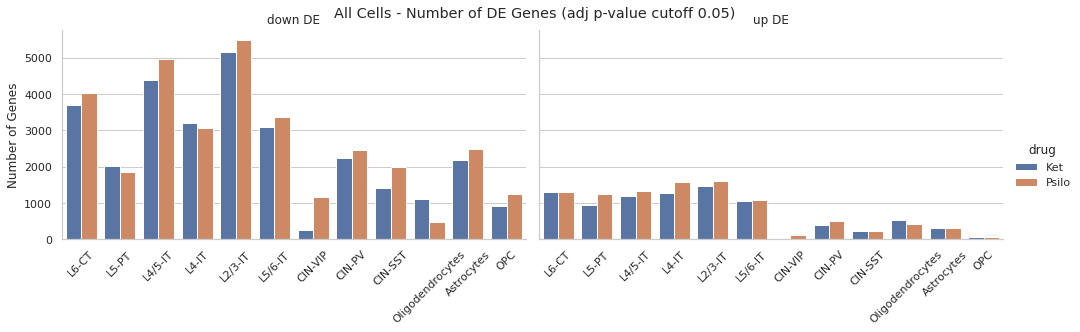

In [19]:
de_counts = memento_full.query('initial_de_padj < 0.050').copy()
de_counts['de_direction'] = de_counts['initial_de'].apply(lambda de: 'up' if de > 0 else 'down')
de_counts = de_counts.groupby(['cluster','drug','de_direction'])['gene'].size() \
    .reset_index() \
    .merge(cluster_lookup, how='left', left_on='cluster', right_on='id') \
    .sort_values('name')

sns.set_theme(style='whitegrid')
g = sns.catplot(
    data=de_counts, kind='bar',
    x='name', y='gene', hue='drug', col='de_direction',
    col_order=['down','up'],
    height=4, aspect=16.0/9,
)
g.set_titles(template='{col_name} DE') \
    .set_axis_labels(x_var='', y_var='Number of Genes') \
    .set_xticklabels(rotation=45)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("All Cells - Number of DE Genes (adj p-value cutoff 0.05)")

Compare to number of cells per group

In [20]:
combo_cell_counts = adata.obs[['drug','leiden', 'name',]].copy()
combo_cell_counts = combo_cell_counts[(combo_cell_counts['leiden'].isin(clusters))]
combo_cell_counts = combo_cell_counts.groupby(['name','drug']).size().reset_index().rename(columns={0:'cells'})
combo_cell_counts = combo_cell_counts[combo_cell_counts['drug'].isin(trt_drugs)]
combo_cell_counts

name   drug  cells
0              L6-CT    Ket  15654
1              L6-CT  Psilo  16330
3              L5-ET    Ket   5945
4              L5-ET  Psilo   5952
6            L4/5-IT    Ket  14627
7            L4/5-IT  Psilo  14263
9              L4-IT    Ket  10776
10             L4-IT  Psilo  10200
12           L2/3-IT    Ket  17264
13           L2/3-IT  Psilo  18472
15           L5/6-IT    Ket   8569
16           L5/6-IT  Psilo   8739
18           CIN-VIP    Ket   3544
19           CIN-VIP  Psilo   3631
21            CIN-PV    Ket   5736
22            CIN-PV  Psilo   6011
24           CIN-SST    Ket   4274
25           CIN-SST  Psilo   4491
27  Oligodendrocytes    Ket   9352
28  Oligodendrocytes  Psilo   8111
30        Astrocytes    Ket   6182
31        Astrocytes  Psilo   7079
33               OPC    Ket   4474
34               OPC  Psilo   4781

Text(0.5, 0.98, 'Cell Counts')

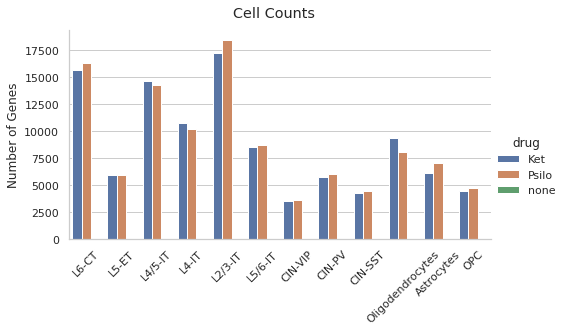

In [21]:
sns.set_theme(style='whitegrid')
g = sns.catplot(
    data=combo_cell_counts, kind='bar',
    x='name', y='cells', hue='drug',
    height=4, aspect=16.0/9,
)
g.set_axis_labels(x_var='', y_var='Number of Genes') \
    .set_xticklabels(rotation=45)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Cell Counts")

Compare this distribution to the number of DE genes.

In [22]:
cell_sensitivity = combo_cell_counts.merge(de_counts[['name','drug','de_direction','gene']], how='left', on=['name','drug'])
cell_sensitivity = cell_sensitivity.dropna().set_index(['name'])
# cell_sensitivity['drug'] = pd.get_dummies(cell_sensitivity['drug'])['Ket']
# cell_sensitivity['de_direction'] = pd.get_dummies(cell_sensitivity['de_direction'])['up']
# cell_sensitivity = sm.add_constant(cell_sensitivity, prepend=False)
cell_sensitivity.head(4)

drug  cells de_direction    gene
name                                    
L6-CT    Ket  15654         down  3712.0
L6-CT    Ket  15654           up  1303.0
L6-CT  Psilo  16330         down  4034.0
L6-CT  Psilo  16330           up  1294.0

In [23]:
# save to do regression in R
cell_sensitivity.to_csv('DE_cell_sensitivity.csv')

# Memento DE Gene Overlap - Full Dataset

## Get full memento

wait - it already exists

In [37]:
memento_full.sort_values('initial_de_padj', ascending=False).head()

gene    initial_de  initial_de_padj   drug cluster
11193        Gm30606 -2.706253e-05              1.0  Psilo      12
11788           Eya4  1.806627e-07              1.0  Psilo      10
12100           Slu7  2.450127e-05              1.0    Ket       2
12101       Adamtsl1 -1.577433e-05              1.0    Ket       2
12102  5330439A09Rik -2.534222e-05              1.0    Ket       2

# Cluster Gene Overlap - directional

In [38]:
no_cutoff_de_directional_overlaps = memento_full.copy()
no_cutoff_de_directional_overlaps['de_direction'] = no_cutoff_de_directional_overlaps['initial_de'].apply(lambda de: 'up' if de > 0 else 'down')
no_cutoff_de_directional_overlaps = no_cutoff_de_directional_overlaps.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
no_cutoff_de_directional_overlaps = no_cutoff_de_directional_overlaps[['gene','drug','name','de_direction','initial_de','initial_de_padj']]
no_cutoff_de_directional_overlaps = no_cutoff_de_directional_overlaps.sort_values('name')
no_cutoff_de_directional_overlap_groups = no_cutoff_de_directional_overlaps.groupby(['drug','de_direction','name']) 
no_cutoff_de_directional_overlaps = {}
for name, group in no_cutoff_de_directional_overlap_groups:
    no_cutoff_de_directional_overlaps[name] = group.sort_values('initial_de_padj', ascending=True) \
         .reset_index() \
         .loc[0:999]
    
del no_cutoff_de_directional_overlap_groups
no_cutoff_de_directional_overlaps

{('Ket',
  'down',
  'L6-CT'):      index      gene drug   name de_direction  initial_de  initial_de_padj
 0    12256      Sox8  Ket  L6-CT         down   -0.821171         0.000107
 1    12263  Tnfrsf21  Ket  L6-CT         down   -0.278620         0.000329
 2    12257     Nr4a1  Ket  L6-CT         down   -0.393813         0.000329
 3    12258    Coq10b  Ket  L6-CT         down   -0.521402         0.000329
 4    12259     Dusp3  Ket  L6-CT         down   -0.267588         0.000329
 ..     ...       ...  ...    ...          ...         ...              ...
 995  13523     Rab30  Ket  L6-CT         down   -0.112241         0.002976
 996  13534    Fyttd1  Ket  L6-CT         down   -0.108167         0.002982
 997  13537   Gm10010  Ket  L6-CT         down   -0.315318         0.002982
 998  13535     Ap3b2  Ket  L6-CT         down   -0.111261         0.002982
 999  13538    C2cd2l  Ket  L6-CT         down   -0.271980         0.002982
 
 [1000 rows x 7 columns],
 ('Ket',
  'down',
  'L5-ET'):

In [39]:
def jaccard_similarity(A, B):
    A_genes, B_genes = set(A['gene']) , set(B['gene'])
    return len(A_genes.intersection(B_genes)) / len(A_genes.union(B_genes))

def cosine_similarity(A, B):
    A_df = A[['gene', 'initial_de']]
    B_df = B[['gene', 'initial_de']]
    union_folds = A_df.merge(B_df, on='gene', how='outer').fillna(0)
    A_folds = union_folds['initial_de_x'].to_numpy()
    B_folds = union_folds['initial_de_y'].to_numpy()
    return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))

In [40]:
def directional_overlap_matrix(drug, direction, similarity_function=jaccard_similarity):
    heatmap_idx = cluster_lookup['name'].to_list()
    similarities = np.zeros((len(heatmap_idx), len(heatmap_idx)))
    for i,i_name in enumerate(heatmap_idx):
        for j,j_name in enumerate(heatmap_idx):
            try:
                A = no_cutoff_de_directional_overlaps[(drug,direction,i_name)]
                B = no_cutoff_de_directional_overlaps[(drug,direction,j_name)]
            except KeyError:
                similarities[i][j] = 0
                continue
            if i == j:
                similarities[i][j] = None
                continue
            
            similarities[i][j] = similarity_function(A, B)
    return similarities

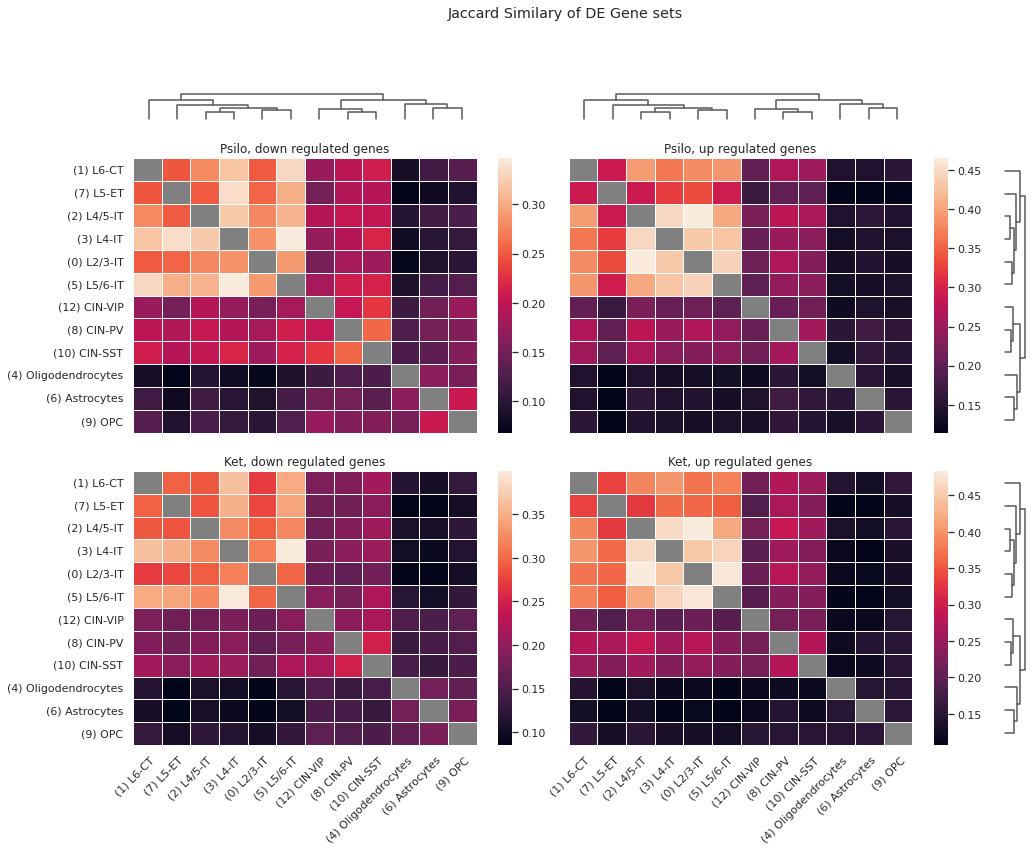

In [41]:
gs_kw = dict(width_ratios=[2,2,0.1], height_ratios=[0.2,2,2],
            wspace=0.02, hspace=0.2)
fig, axes = plt.subplots(3, 3, figsize=(16, 12), gridspec_kw=gs_kw)

heatmap_drugs = ['Psilo','Ket']
heatmap_directions = ['down','up']
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

axes[0][2].remove()
for ax in [axes[0][0], axes[0][1]]:
    sc.pl.dendrogram(adata, 'leiden', orientation='top', remove_labels=True, show=False, ax=ax)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax+30)
    
for ax in [axes[1][2], axes[2][2]]:
    sc.pl.dendrogram(adata, 'leiden', orientation='right', remove_labels=True, show=False, ax=ax)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymax, ymin)

for i,j in itertools.product([0,1], [0,1]):
    row, col = i+1 , j
    sns.heatmap(
        directional_overlap_matrix(heatmap_drugs[i], heatmap_directions[j], jaccard_similarity), 
        linewidth=0.5, 
        ax=axes[row][col]
    )
    axes[row][col].set_facecolor('grey')
    axes[row][col].set_title(f"{heatmap_drugs[i]}, {heatmap_directions[j]} regulated genes")
    if row==2:
        axes[row][col].set_xticks(np.arange(len(heatmap_idx))+0.8, labels=heatmap_cluster_labels, rotation=45, ha='right')
    else:
        axes[row][col].set_xticks([])
    if col==0:
        axes[row][col].set_yticks(np.arange(len(heatmap_idx))+0.5, labels=heatmap_cluster_labels, rotation=0)
    else:
        axes[row][col].set_yticks([])

fig.suptitle("Jaccard Similary of DE Gene sets")
fig.savefig(os.path.join(settings.fig_path, "full_heatmap_de_gene_overlap_jaccard.png"))
fig.savefig(os.path.join(settings.fig_path, "vectors", "full_heatmap_de_gene_overlap_jaccard.pdf"))

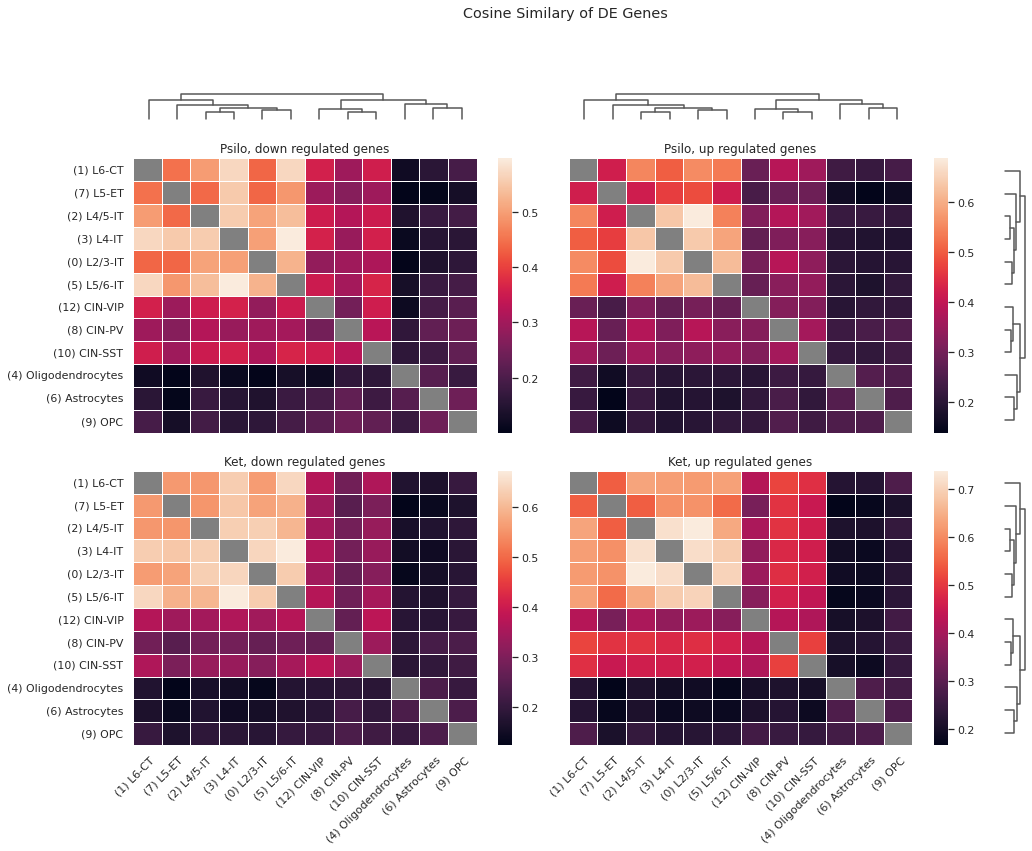

In [42]:
gs_kw = dict(width_ratios=[2,2,0.1], height_ratios=[0.2,2,2],
            wspace=0.02, hspace=0.2)
fig, axes = plt.subplots(3, 3, figsize=(16, 12), gridspec_kw=gs_kw)

heatmap_drugs = ['Psilo','Ket']
heatmap_directions = ['down','up']
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

axes[0][2].remove()
for ax in [axes[0][0], axes[0][1]]:
    sc.pl.dendrogram(adata, 'leiden', orientation='top', remove_labels=True, show=False, ax=ax)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax+30)
    
for ax in [axes[1][2], axes[2][2]]:
    sc.pl.dendrogram(adata, 'leiden', orientation='right', remove_labels=True, show=False, ax=ax)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymax, ymin)

for i,j in itertools.product([0,1], [0,1]):
    row, col = i+1 , j
    sns.heatmap(
        directional_overlap_matrix(heatmap_drugs[i], heatmap_directions[j], cosine_similarity), 
        linewidth=0.5, 
        ax=axes[row][col]
    )
    axes[row][col].set_facecolor('grey')
    axes[row][col].set_title(f"{heatmap_drugs[i]}, {heatmap_directions[j]} regulated genes")
    if row==2:
        axes[row][col].set_xticks(np.arange(len(heatmap_idx))+0.8, labels=heatmap_cluster_labels, rotation=45, ha='right')
    else:
        axes[row][col].set_xticks([])
    if col==0:
        axes[row][col].set_yticks(np.arange(len(heatmap_idx))+0.5, labels=heatmap_cluster_labels, rotation=0)
    else:
        axes[row][col].set_yticks([])

fig.suptitle("Cosine Similary of DE Genes")
fig.savefig(os.path.join(settings.fig_path, "full_heatmap_de_gene_overlap_cosine.png"))
fig.savefig(os.path.join(settings.fig_path, "vectors", "full_heatmap_de_gene_overlap_cosine.pdf"))

## Gene Intersection Lists

In [70]:
def directional_intersect_list(drug:str, direction:str, clusters:list[str]):
    overlap_df = no_cutoff_de_directional_overlaps[(drug,direction,clusters[0])]
    these_genes = set(overlap_df['gene'])
    for cluster in clusters[1:]:
        overlap_df = no_cutoff_de_directional_overlaps[(drug,direction,cluster)]
        these_genes = these_genes.intersection(set(overlap_df['gene']))
    return sorted(list(these_genes))

heatmap_drugs = ['Psilo','Ket']
heatmap_directions = ['down','up']
cluster_groups = {
    'IT': ['L2/3-IT', 'L4/5-IT', 'L4-IT', 'L5/6-IT'],
    'layers': ['L2/3-IT','L4/5-IT','L4-IT','L5/6-IT','L6-CT','L5-ET'],
    'neurons': ['L2/3-IT','L4/5-IT','L4-IT','L5/6-IT','L6-CT','L5-ET','CIN-PV','CIN-SST','CIN-VIP'],
    'CIN': ['CIN-PV','CIN-SST','CIN-VIP']
}
excel_writer = pd.ExcelWriter('directional_time_covariate_cluster_group_gene_intersections.xlsx', date_format=None, mode='w')

group_metadata = pd.concat([pd.Series(clusters) for group,clusters in cluster_groups.items()], ignore_index=True, axis=1)
group_metadata.columns = ['IT', 'layers', 'neurons', 'CIN']
group_metadata.to_excel(excel_writer, sheet_name='group_metadata', index=False)

for drug,direction in itertools.product(heatmap_drugs, heatmap_directions):
    intersect_lists = [
        directional_intersect_list(drug, direction, cluster_groups['IT']),
        directional_intersect_list(drug, direction, cluster_groups['layers']),
        directional_intersect_list(drug, direction, cluster_groups['neurons']),
        directional_intersect_list(drug, direction, cluster_groups['CIN'])
    ]
    df = pd.concat([pd.Series(l) for l in intersect_lists], ignore_index=True, axis=1)
    df.columns = ['IT', 'layers', 'neurons', 'CIN']
    df.to_excel(excel_writer, sheet_name=f'{drug}_{direction}', index=False)
    
excel_writer.close()

# Cluster Gene Overlap - nondirectional

In [43]:
no_cutoff_de_overlaps = memento_full.copy()
no_cutoff_de_overlaps = no_cutoff_de_overlaps.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
no_cutoff_de_overlaps = no_cutoff_de_overlaps[['gene','drug','name','initial_de','initial_de_padj']]
no_cutoff_de_overlaps = no_cutoff_de_overlaps.sort_values('name')
no_cutoff_de_overlap_groups = no_cutoff_de_overlaps.groupby(['drug','name']) 
no_cutoff_de_overlaps = {}
for name, group in no_cutoff_de_overlap_groups:
    no_cutoff_de_overlaps[name] = group.sort_values('initial_de_padj', ascending=True) \
         .reset_index() \
         .loc[0:999]
    
del no_cutoff_de_overlap_groups
no_cutoff_de_overlaps[('Ket','Astrocytes')]

index     gene drug        name  initial_de  initial_de_padj
0    69573    Fkbp5  Ket  Astrocytes    1.671868         0.001746
1    69574    Asic2  Ket  Astrocytes    0.377218         0.004261
2    69575    Cdh19  Ket  Astrocytes    0.186463         0.004261
3    69576  Galnt18  Ket  Astrocytes    0.443445         0.004261
4    69577     Dbx2  Ket  Astrocytes   -0.266200         0.005521
..     ...      ...  ...         ...         ...              ...
995  70565      Rdx  Ket  Astrocytes   -0.253106         0.014474
996  70559   Shisa4  Ket  Astrocytes   -0.180368         0.014474
997  70563     Chfr  Ket  Astrocytes   -0.183970         0.014474
998  70562  Gm28175  Ket  Astrocytes   -0.281938         0.014474
999  70561    Htra1  Ket  Astrocytes    0.084026         0.014474

[1000 rows x 6 columns]

In [44]:
def non_directional_overlap_matrix(drug, similarity_function):
    heatmap_idx = cluster_lookup['name'].to_list()
    similarities = np.zeros((len(heatmap_idx), len(heatmap_idx)))
    for i,i_name in enumerate(heatmap_idx):
        for j,j_name in enumerate(heatmap_idx):
            try:
                A = no_cutoff_de_overlaps[(drug,i_name)]
                B = no_cutoff_de_overlaps[(drug,j_name)]
            except KeyError:
                similarities[i][j] = 0
                continue
            if i == j:
                similarities[i][j] = None
                continue
            
            similarities[i][j] = similarity_function(A, B)
    return similarities

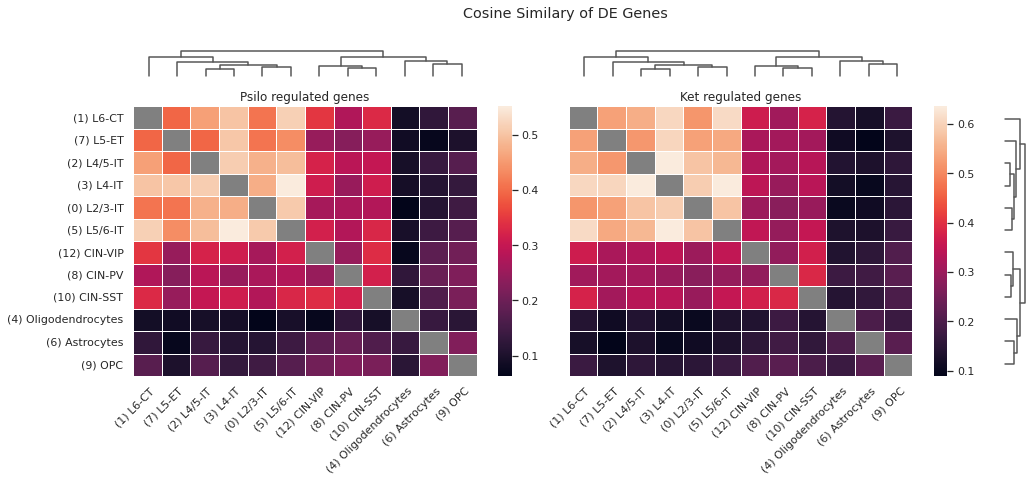

In [45]:
gs_kw = dict(width_ratios=[2,2,0.1], height_ratios=[0.2,2],
            wspace=0.02, hspace=0.2)
fig, axes = plt.subplots(2, 3, figsize=(16, 6), gridspec_kw=gs_kw)
heatmap_drugs = ['Psilo','Ket']
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

axes[0][2].remove()
for ax in [axes[0][0], axes[0][1]]:
    sc.pl.dendrogram(adata, 'leiden', orientation='top', remove_labels=True, show=False, ax=ax)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax+30)
    
for ax in [axes[1][2]]:
    sc.pl.dendrogram(adata, 'leiden', orientation='right', remove_labels=True, show=False, ax=ax)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymax, ymin)
    
for col in [0,1]:
    sns.heatmap(
        non_directional_overlap_matrix(heatmap_drugs[col], cosine_similarity), 
        linewidth=0.5, 
        ax=axes[1][col]
    )
    axes[1][col].set_facecolor('grey')
    
    axes[1][col].set_title(f"{heatmap_drugs[col]} regulated genes")
    axes[1][col].set_xticks(np.arange(len(heatmap_idx))+0.8, labels=heatmap_cluster_labels, rotation=45, ha='right')
    if col==0:
        axes[1][col].set_yticks(np.arange(len(heatmap_idx))+0.5, labels=heatmap_cluster_labels, rotation=0)
    else:
        axes[1][col].set_yticks([])
    
fig.suptitle("Cosine Similary of DE Genes")
fig.savefig(os.path.join(settings.fig_path, "full_heatmap_de_gene_overlap_cosine_nondirectional.png"))
fig.savefig(os.path.join(settings.fig_path, "vectors", "full_heatmap_de_gene_overlap_cosine_nondirectional.pdf"))

## Overlap Swoosh Grids

In [97]:
def swoosh_matrix_underlying_data(drug_1, cluster_1, drug_2, cluster_2):
    cluster_1_genes = no_cutoff_de_overlaps[(drug_1,cluster_1)]['gene']

    memento_with_cluster_names = memento_full \
        .merge(cluster_lookup, how='inner', left_on='cluster', right_on='id')
    drug_cluster_1_memento = memento_with_cluster_names.query(f"drug=='{drug_1}' and name=='{cluster_1}'") \
        .set_index('gene')[['initial_de']] \
        .rename(columns={'initial_de': 'home'})
    drug_cluster_2_memento = memento_with_cluster_names.query(f"drug=='{drug_2}' and name=='{cluster_2}'") \
        .set_index('gene')[['initial_de']] \
        .rename(columns={'initial_de': 'away'})
    
    result = drug_cluster_1_memento.join(drug_cluster_2_memento, how='left')
    return result.loc[cluster_1_genes, ['home','away']] \
        .sort_values('home', ascending=False)
    
def swoosh_matrix_fc(drug_1, cluster_1, drug_2, cluster_2):
    df = swoosh_matrix_underlying_data(drug_1, cluster_1, drug_2, cluster_2)
    def scale_directional(x):
        if x >= 0:
            return df['home'].max() * x / df['away'].max()
        else:
            return df['home'].min() * x / df['away'].min()
    df['away'] = df['away'].apply(scale_directional)
    return df.round(5)

def swoosh_matrix_rank(drug_1, cluster_1, drug_2, cluster_2):
    df = swoosh_matrix_underlying_data(drug_1, cluster_1, drug_2, cluster_2)
    df = df.rank()
    df = (df - 1) / (df['home'].max() - 1)
    return df

# print(swoosh_matrix_fc('Psilo', 'L5/6-NP', 'Ket', 'L5-ET').head())
# swoosh_matrix_underlying_data('Ket', 'Astrocytes', 'Psilo', 'L6-CT')

In [98]:
ZERO_CENTER_COLOR_NORM = mcolors.TwoSlopeNorm(vcenter=0)
NO_COLOR_NORM = mcolors.NoNorm()

### Heatmap of FC

CPU times: user 3.48 s, sys: 2.09 s, total: 5.56 s
Wall time: 4min 20s


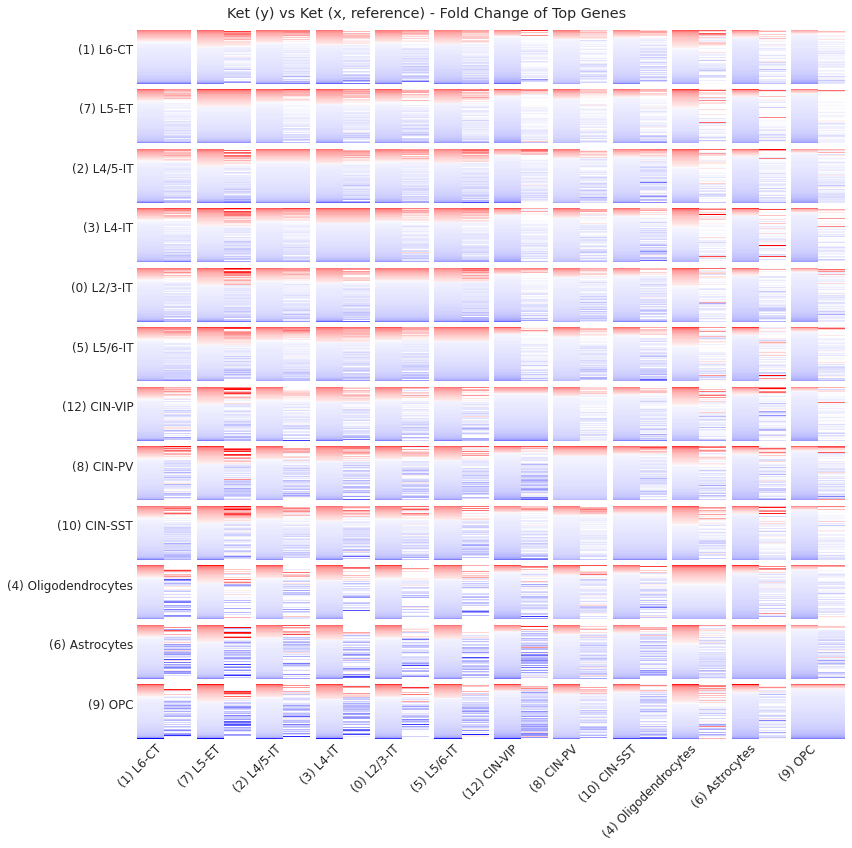

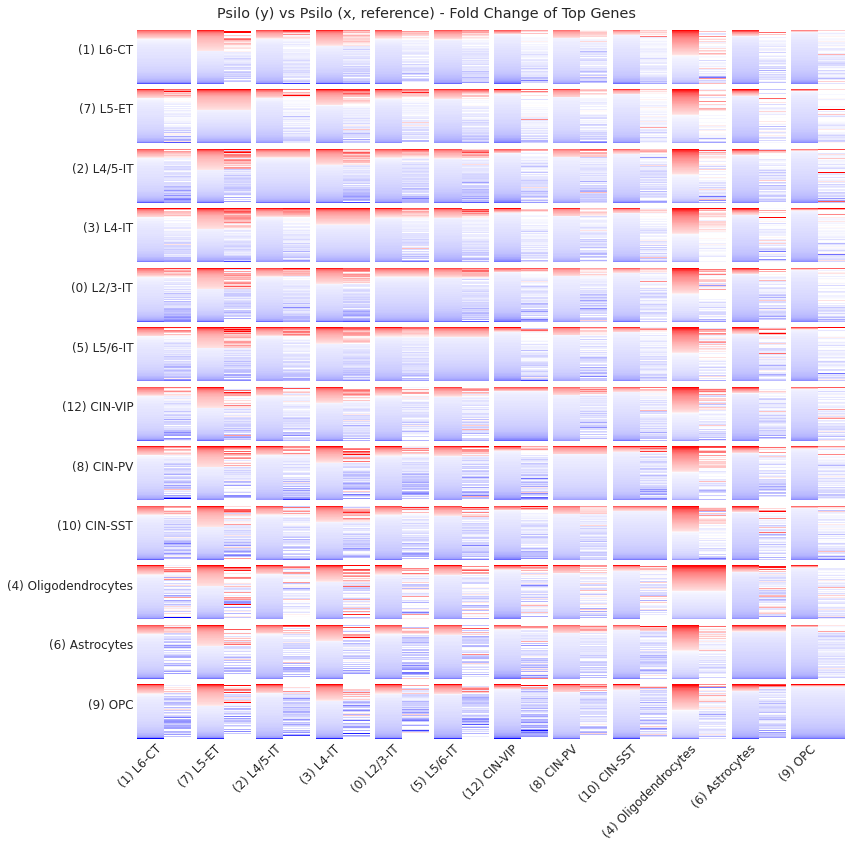

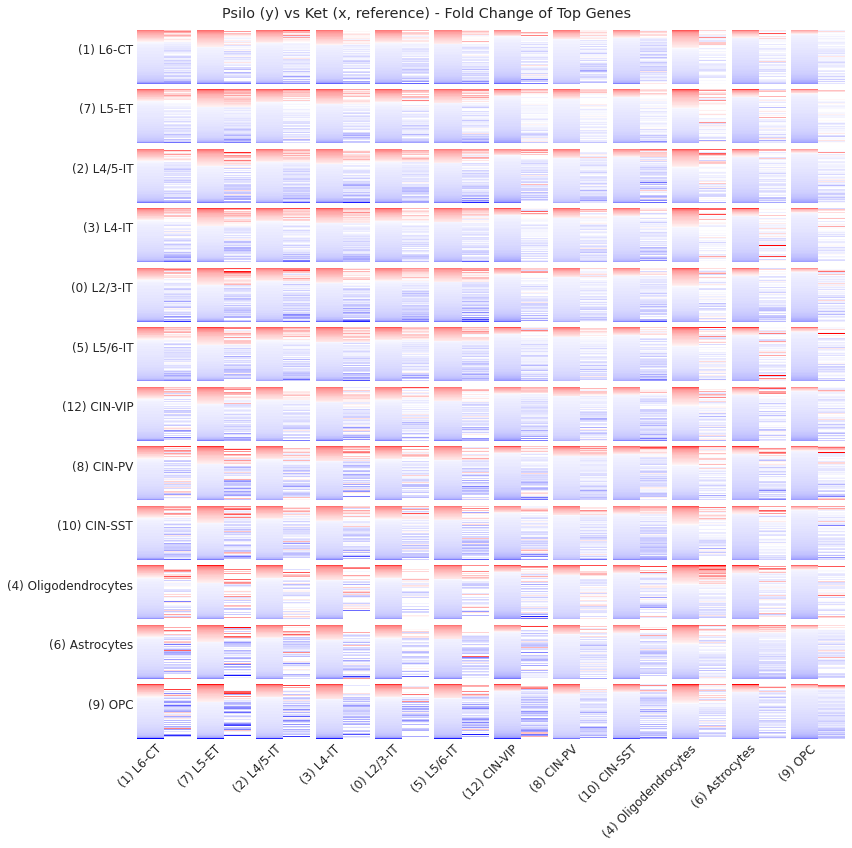

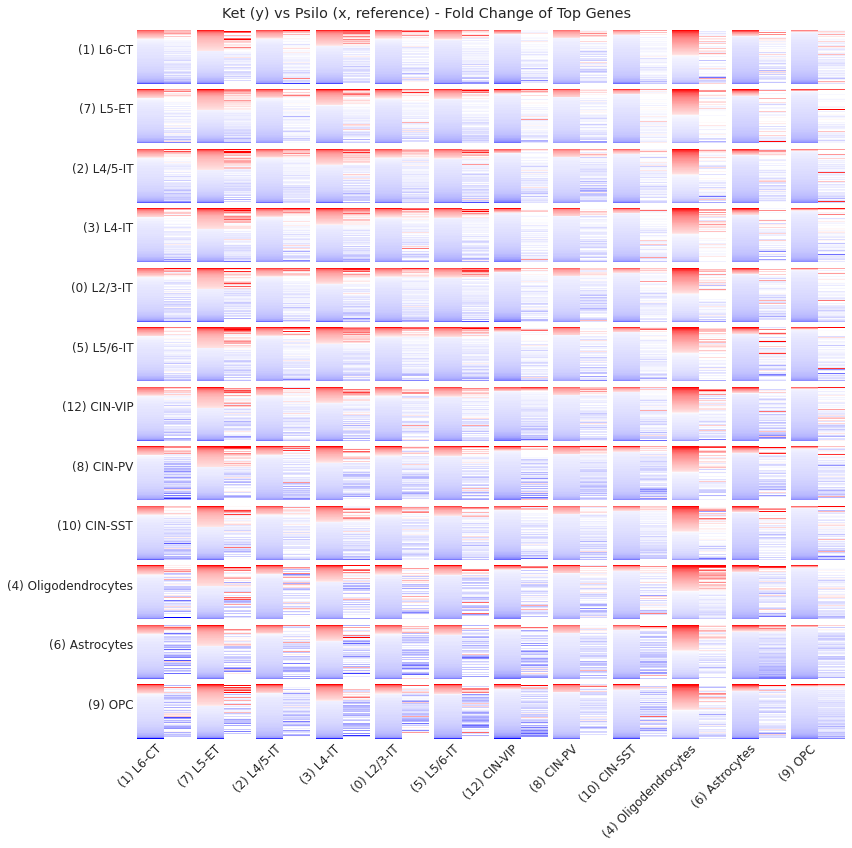

In [51]:
%%time

def swoosh_grid_heatmap_fc(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

    for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
#     for row, col in itertools.product([0,1,11,12], [0,1,2]):
        ax = axes[row][col]
        sns.heatmap(
            data = swoosh_matrix_fc(drug_reference, heatmap_idx[col], drug_comparison, heatmap_idx[row]),
            cmap='bwr', norm=ZERO_CENTER_COLOR_NORM,
            linewidth=0, cbar=False,
            xticklabels=False, yticklabels=False,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
        if row == len(heatmap_idx)-1:
            ax.set_xlabel(heatmap_cluster_labels[col], rotation = 45, horizontalalignment='right')
        if col == 0:
            ax.set_ylabel(heatmap_cluster_labels[row], rotation = 0, horizontalalignment='right')

    fig.suptitle(f'{drug_comparison} (y) vs {drug_reference} (x, reference) - Fold Change of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_swoosh_grid_heatmap_fc_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_swoosh_grid_heatmap_fc_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

def multiprocess_swoosh_grid_heatmap_fc():
    pool = multiprocessing.Pool(4)
    drug_pairings = itertools.product(['Psilo','Ket'], ['Psilo','Ket'])
    pool.map(swoosh_grid_heatmap_fc, drug_pairings)

multiprocess_swoosh_grid_heatmap_fc()

### Heatmap of Rank

CPU times: user 5.19 s, sys: 2.11 s, total: 7.3 s
Wall time: 4min 19s


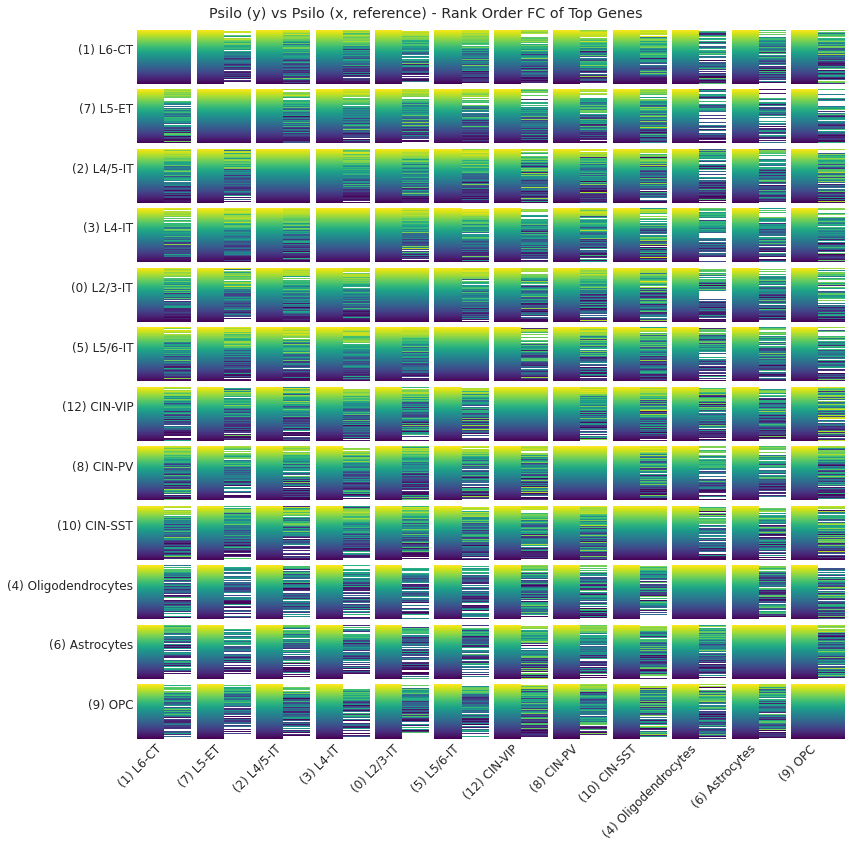

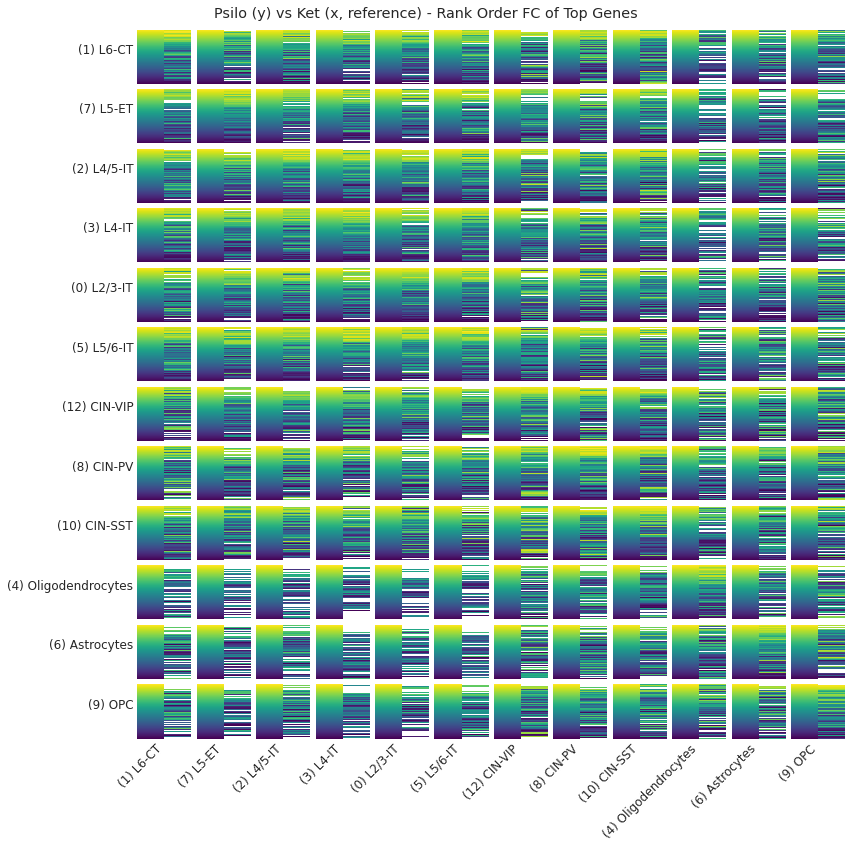

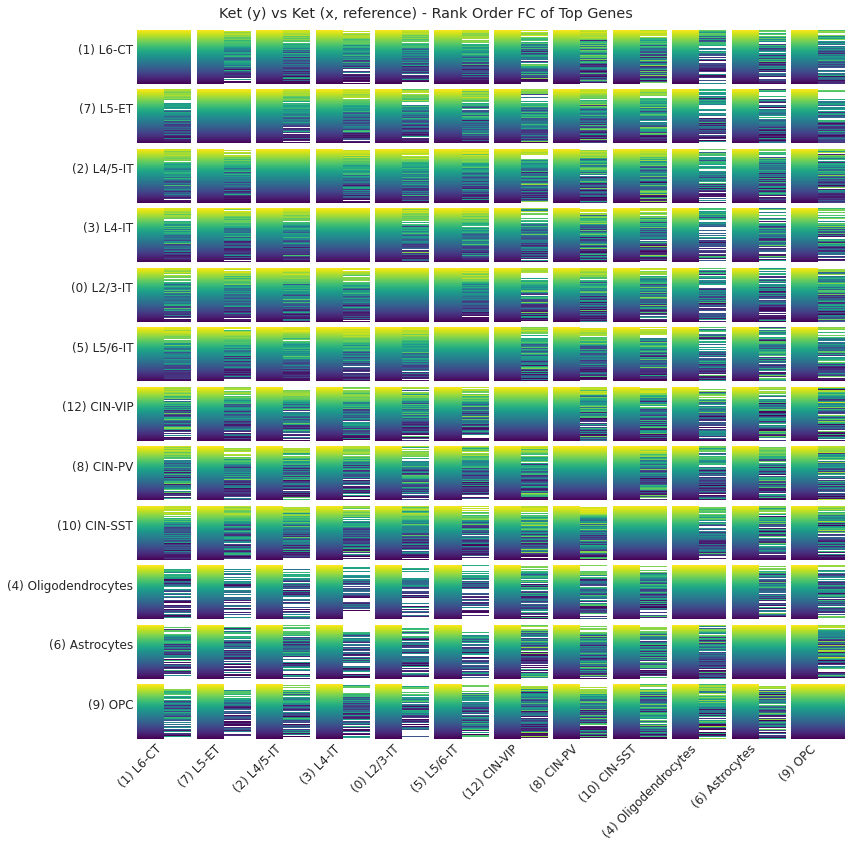

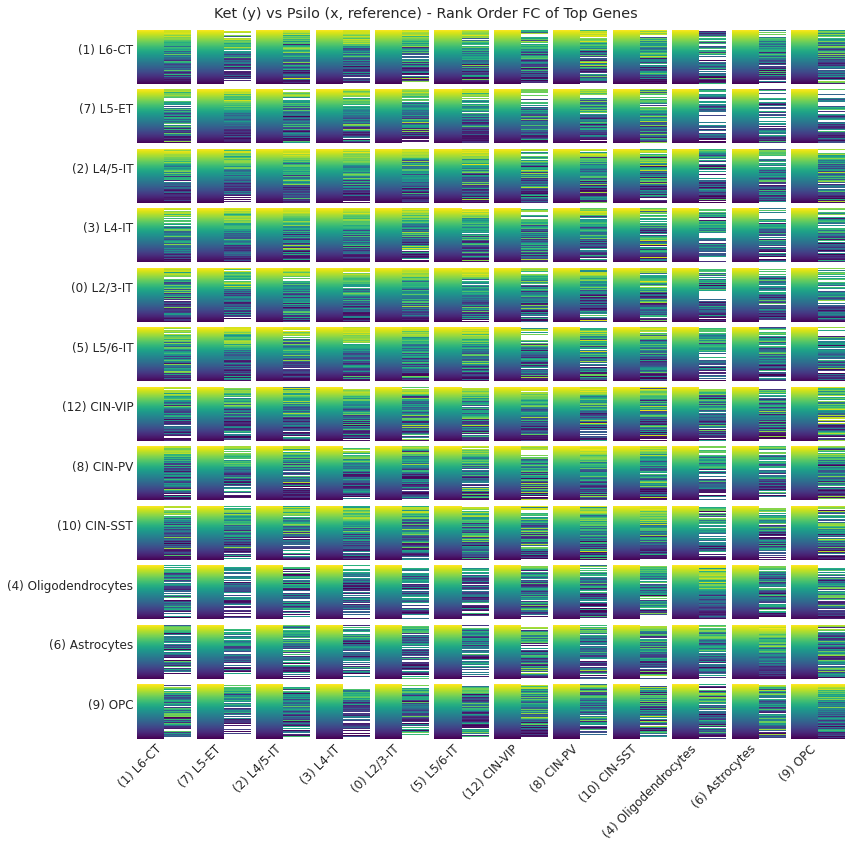

In [52]:
%%time

def swoosh_grid_heatmap_rank(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

    for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
    # for row, col in itertools.product([0,1,11,12], [0,1,2]):
        ax = axes[row][col]
        sns.heatmap(
            data = swoosh_matrix_rank(drug_reference, heatmap_idx[col], drug_comparison, heatmap_idx[row]).loc[:,['home','away']],
            cmap='viridis', norm=NO_COLOR_NORM,
            linewidth=0, cbar=False,
            xticklabels=False, yticklabels=False,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
        if row == len(heatmap_idx)-1:
            ax.set_xlabel(heatmap_cluster_labels[col], rotation = 45, horizontalalignment='right')
        if col == 0:
            ax.set_ylabel(heatmap_cluster_labels[row], rotation = 0, horizontalalignment='right')

    fig.suptitle(f'{drug_comparison} (y) vs {drug_reference} (x, reference) - Rank Order FC of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_swoosh_grid_heatmap_rank_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_swoosh_grid_heatmap_rank_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

def multiprocess_swoosh_grid_heatmap_rank():
    pool = multiprocessing.Pool(4)
    drug_pairings = itertools.product(['Psilo','Ket'], ['Psilo','Ket'])
    pool.map(swoosh_grid_heatmap_rank, drug_pairings)

multiprocess_swoosh_grid_heatmap_rank()

### Glyphs of FC Residuals

In [105]:
df = swoosh_matrix_fc('Psilo', 'L5-ET', 'Psilo', 'L6-CT').dropna()
np.corrcoef(df['home'], df['away'])[0,1]

0.891914700984038

CPU times: user 5.72 s, sys: 3.56 s, total: 9.28 s
Wall time: 45.7 s


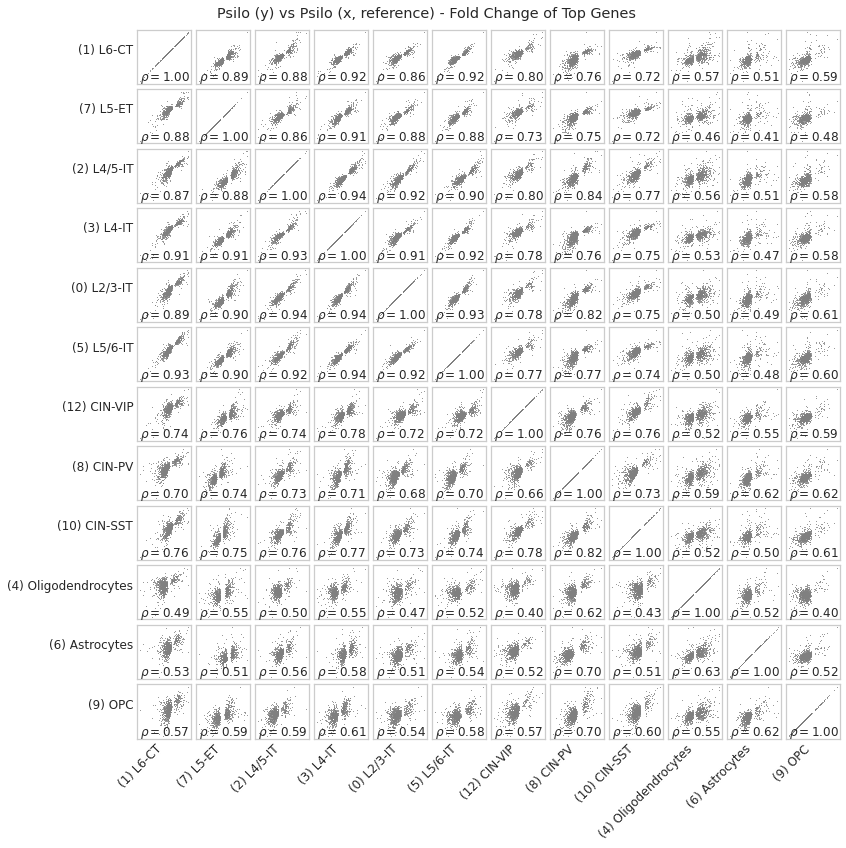

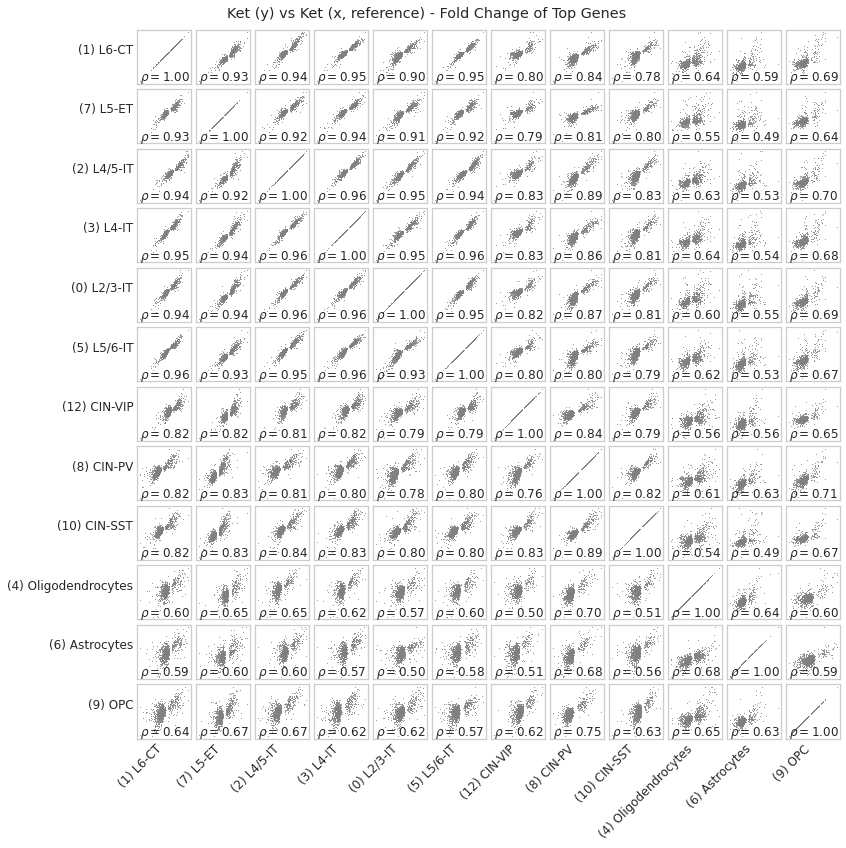

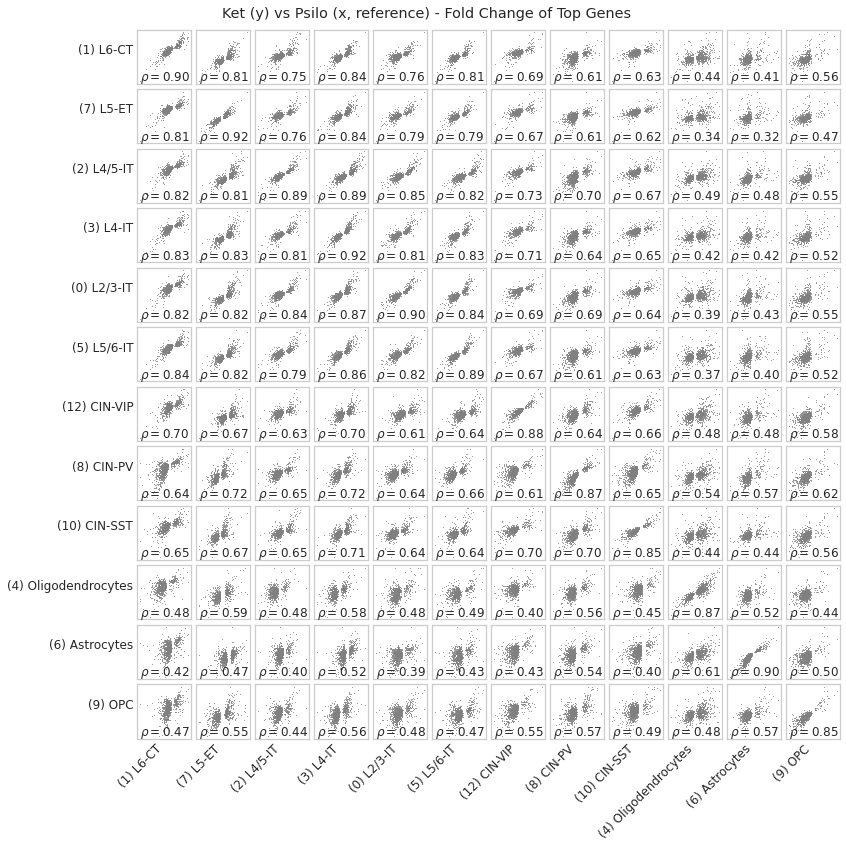

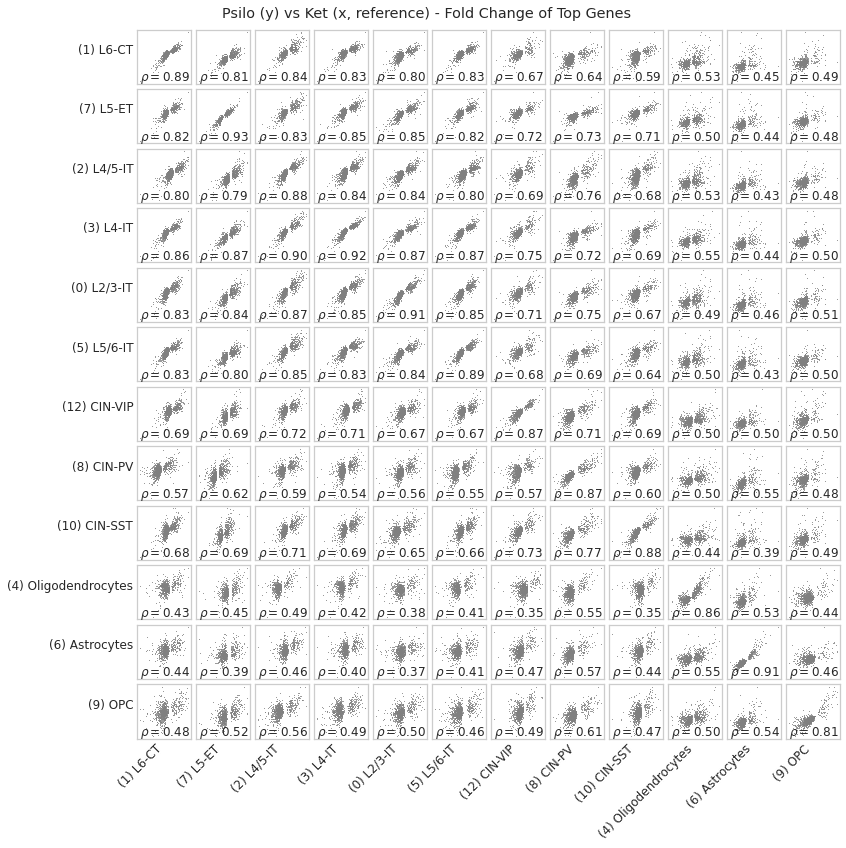

In [140]:
%%time

def swoosh_grid_glyph_fc(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

    for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
#     for row, col in itertools.product([0,1,11], [0,1,2]):
        ax = axes[row][col]
        comparison_data = swoosh_matrix_fc(drug_reference, heatmap_idx[col], drug_comparison, heatmap_idx[row])
        correlation = np.corrcoef(comparison_data.dropna()['home'], comparison_data.dropna()['away'])[0,1]
        sns.scatterplot(
            data = comparison_data,
            x = 'home', y = 'away',
            color = 'grey',
            linewidth=0, s=1,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
        if row == len(heatmap_idx)-1:
            ax.set_xlabel(heatmap_cluster_labels[col], rotation = 45, horizontalalignment='right')
        if col == 0:
            ax.set_ylabel(heatmap_cluster_labels[row], rotation = 0, horizontalalignment='right')

        ax.text(0.05, 0.05, fr'$\rho = {correlation:0.2f}$', transform=ax.transAxes)
    fig.suptitle(f'{drug_comparison} (y) vs {drug_reference} (x, reference) - Fold Change of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_swoosh_grid_glyph_fc_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_swoosh_grid_glyph_fc_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

def multiprocess_swoosh_grid_glyph_fc():
    pool = multiprocessing.Pool(6)
    drug_pairings = itertools.product(['Psilo','Ket'], ['Psilo','Ket'])
    pool.map(swoosh_grid_glyph_fc, drug_pairings)

multiprocess_swoosh_grid_glyph_fc()

### Glyphs of Rank Difference

CPU times: user 6.29 s, sys: 2.35 s, total: 8.64 s
Wall time: 40.7 s


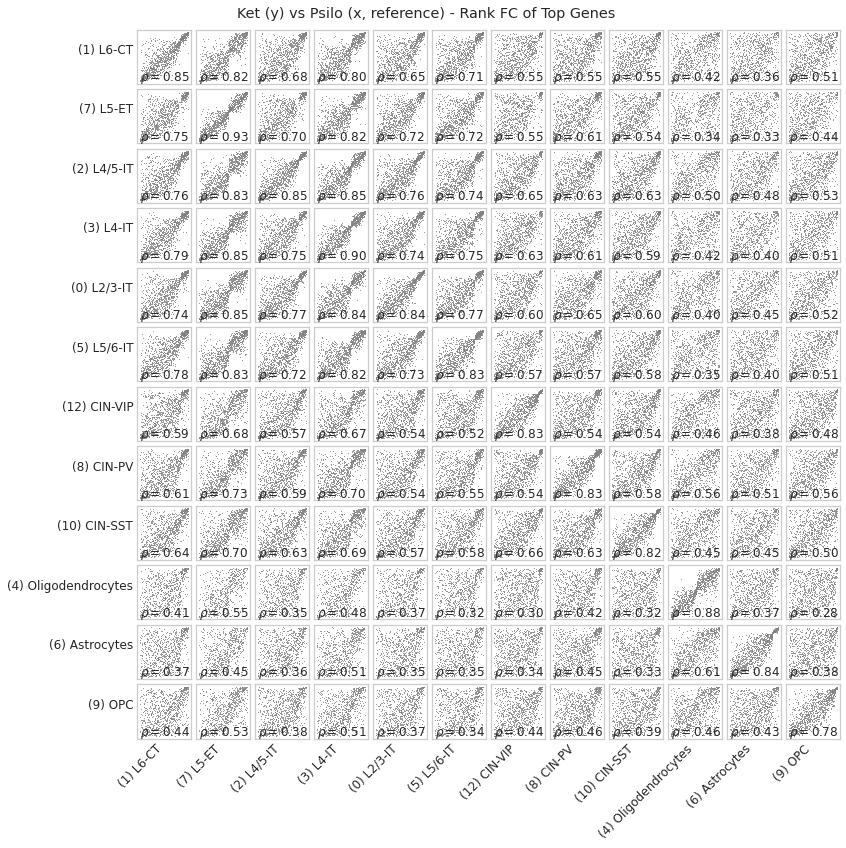

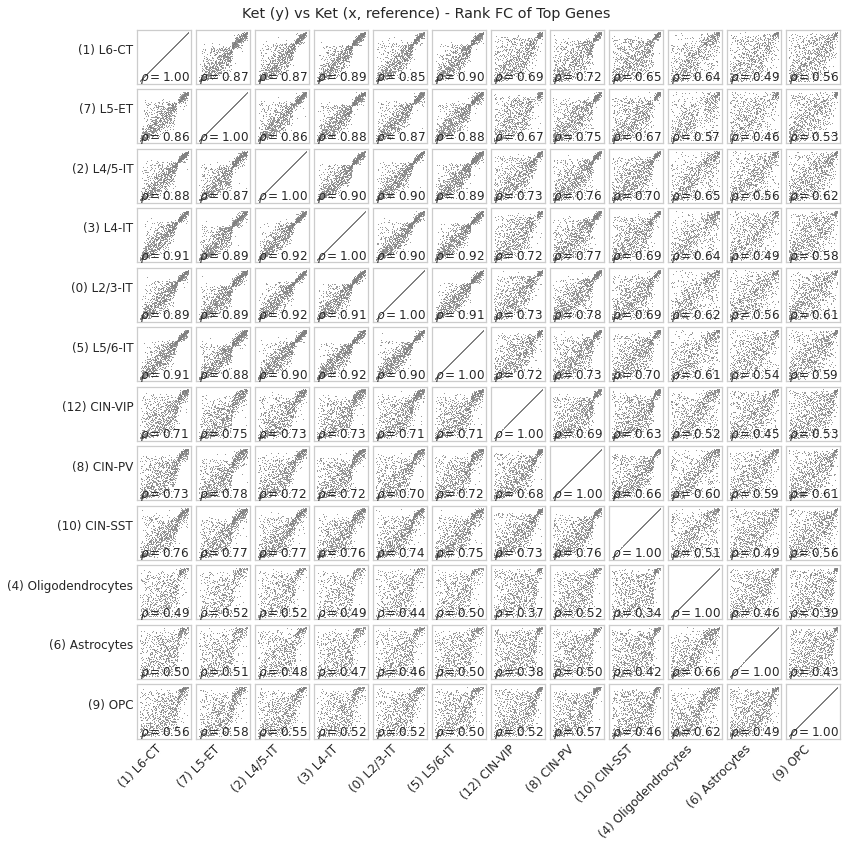

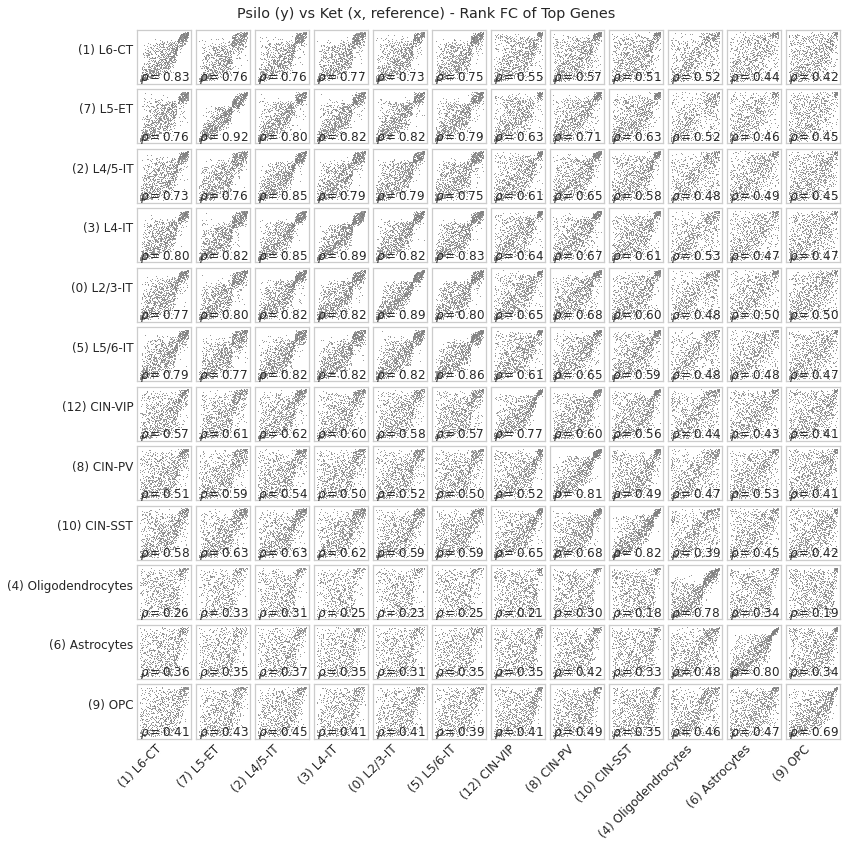

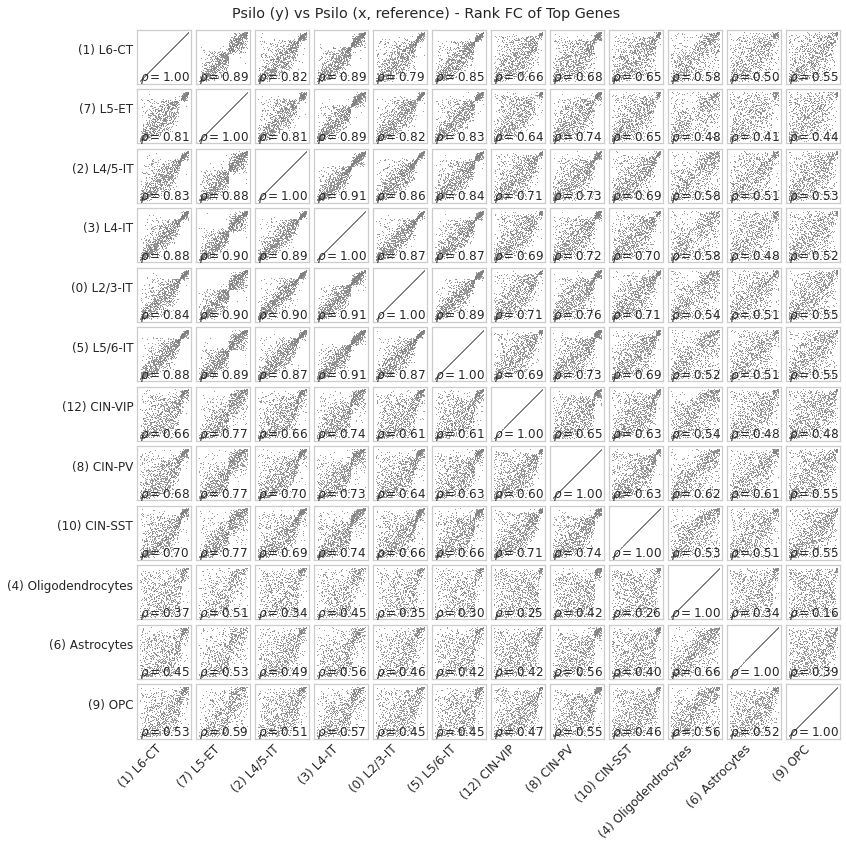

In [141]:
%%time

def swoosh_grid_glyph_rank(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

    for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
#     for row, col in itertools.product([0,1,11,12], [0,1,2]):
        ax = axes[row][col]
        comparison_data = swoosh_matrix_rank(drug_reference, heatmap_idx[col], drug_comparison, heatmap_idx[row])
        correlation = np.corrcoef(comparison_data.dropna()['home'], comparison_data.dropna()['away'])[0,1]

        sns.scatterplot(
            data = comparison_data,
            x = 'home', y = 'away',
            color = 'grey',
            linewidth=0, s=1,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
        if row == len(heatmap_idx)-1:
            ax.set_xlabel(heatmap_cluster_labels[col], rotation = 45, horizontalalignment='right')
        if col == 0:
            ax.set_ylabel(heatmap_cluster_labels[row], rotation = 0, horizontalalignment='right')
        ax.text(0.05, 0.05, fr'$\rho = {correlation:0.2f}$', transform=ax.transAxes)
        
    fig.suptitle(f'{drug_comparison} (y) vs {drug_reference} (x, reference) - Rank FC of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_swoosh_grid_glyph_rank_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_swoosh_grid_glyph_rank_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

def multiprocess_swoosh_grid_glyph_rank():
    pool = multiprocessing.Pool(4)
    drug_pairings = itertools.product(['Psilo','Ket'], ['Psilo','Ket'])
    pool.map(swoosh_grid_glyph_rank, drug_pairings)

multiprocess_swoosh_grid_glyph_rank()

## Inter-drug Same-cluster Comparisons

In [55]:
heatmap_cluster_labels

['(1) L6-CT',
 '(7) L5-ET',
 '(2) L4/5-IT',
 '(3) L4-IT',
 '(0) L2/3-IT',
 '(5) L5/6-IT',
 '(12) CIN-VIP',
 '(8) CIN-PV',
 '(10) CIN-SST',
 '(4) Oligodendrocytes',
 '(6) Astrocytes',
 '(9) OPC']

In [56]:
cosine_similarity(no_cutoff_de_overlaps[('Ket','L6-CT')], no_cutoff_de_overlaps[('Psilo','L6-CT')])

0.5369966095241837

In [57]:
def interdrug_similarity(similarity_function):
    heatmap_idx = cluster_lookup['name'].to_list()
    similarities = np.zeros(len(heatmap_idx))
    for j,j_name in enumerate(heatmap_idx):
        try:
            A = no_cutoff_de_overlaps[('Ket',j_name)]
            B = no_cutoff_de_overlaps[('Psilo',j_name)]
            similarities[j] = similarity_function(A, B)
        except KeyError:
            similarities[j] = 0
            continue
    return pd.DataFrame({'cluster':heatmap_cluster_labels, 'similarity':similarities})

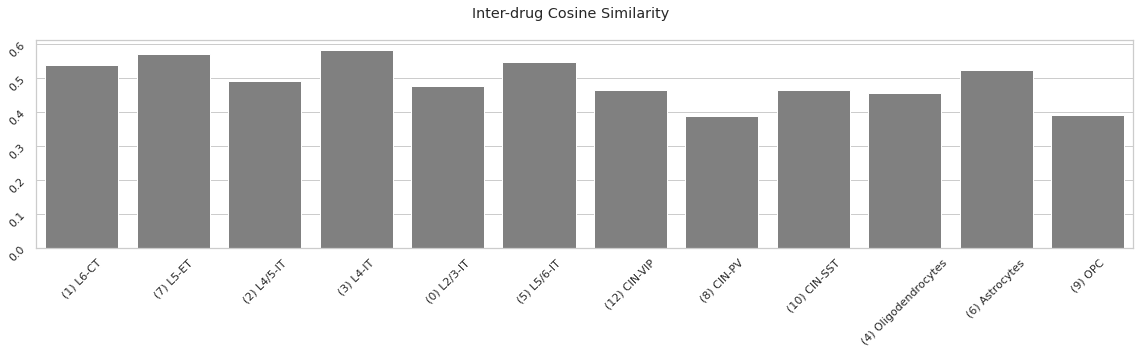

In [58]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(
    data = interdrug_similarity(cosine_similarity),
    x = 'cluster', y = 'similarity',
    color = 'grey',
    ax = ax
)
ax.set(xlabel=None, ylabel=None)
ax.tick_params(labelrotation = 45)
fig.suptitle(f'Inter-drug Cosine Similarity')
fig.tight_layout()
fig.savefig(os.path.join(settings.fig_path, f'full_interdrug_cosine_similarity.png'))
fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_interdrug_cosine_similarity.pdf'))

In [59]:
math.ceil(4)

4

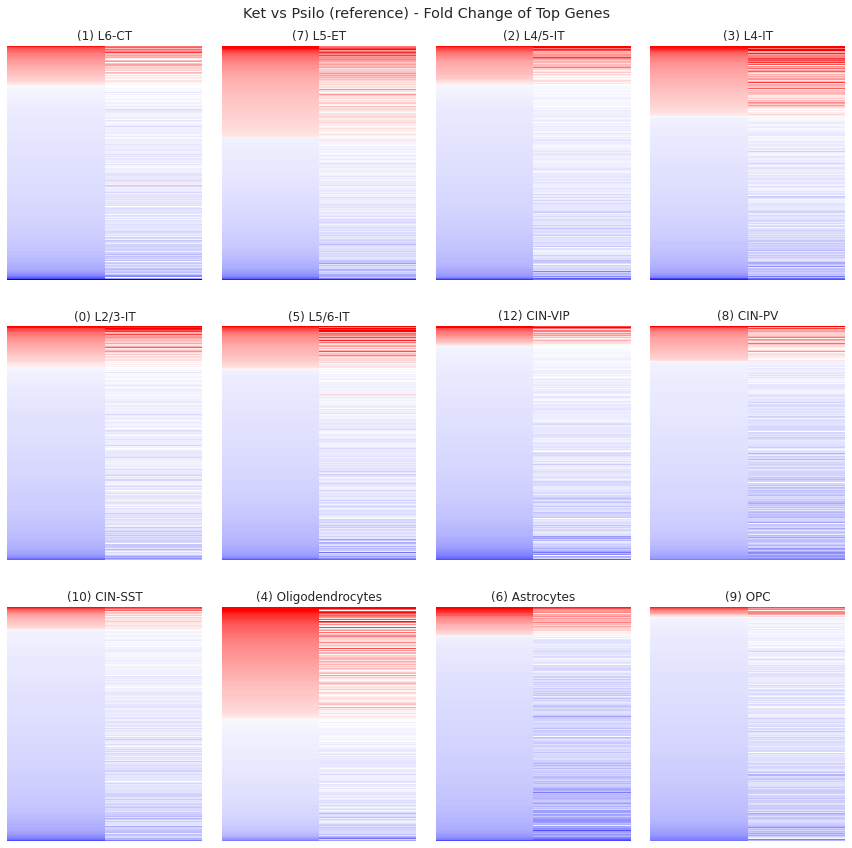

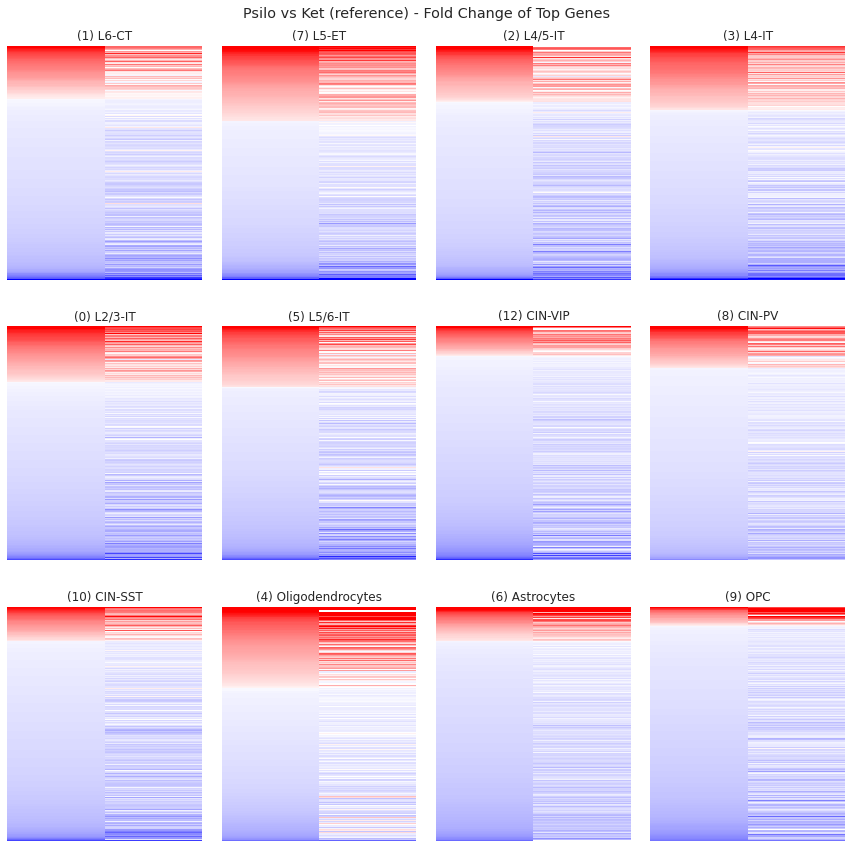

In [60]:
def interdrug_heatmap_fc(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    square_grid_size = math.ceil(math.sqrt(len(heatmap_idx)))
    fig, axes = plt.subplots(math.ceil(len(heatmap_idx) / square_grid_size), square_grid_size, figsize=(12, 12))

    for i in range(len(heatmap_idx)):
        ax = axes[i // square_grid_size][i % square_grid_size]
        sns.heatmap(
            data = swoosh_matrix_fc(drug_reference, heatmap_idx[i], drug_comparison, heatmap_idx[i]),
            cmap='bwr', norm=ZERO_CENTER_COLOR_NORM,
            linewidth=0, cbar=False,
            xticklabels=False, yticklabels=False,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[], title=heatmap_cluster_labels[i])

    fig.suptitle(f'{drug_comparison} vs {drug_reference} (reference) - Fold Change of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_interdrug_heatmap_fc_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_interdrug_heatmap_fc_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

interdrug_heatmap_fc(['Psilo','Ket'])
interdrug_heatmap_fc(['Ket','Psilo'])
pass

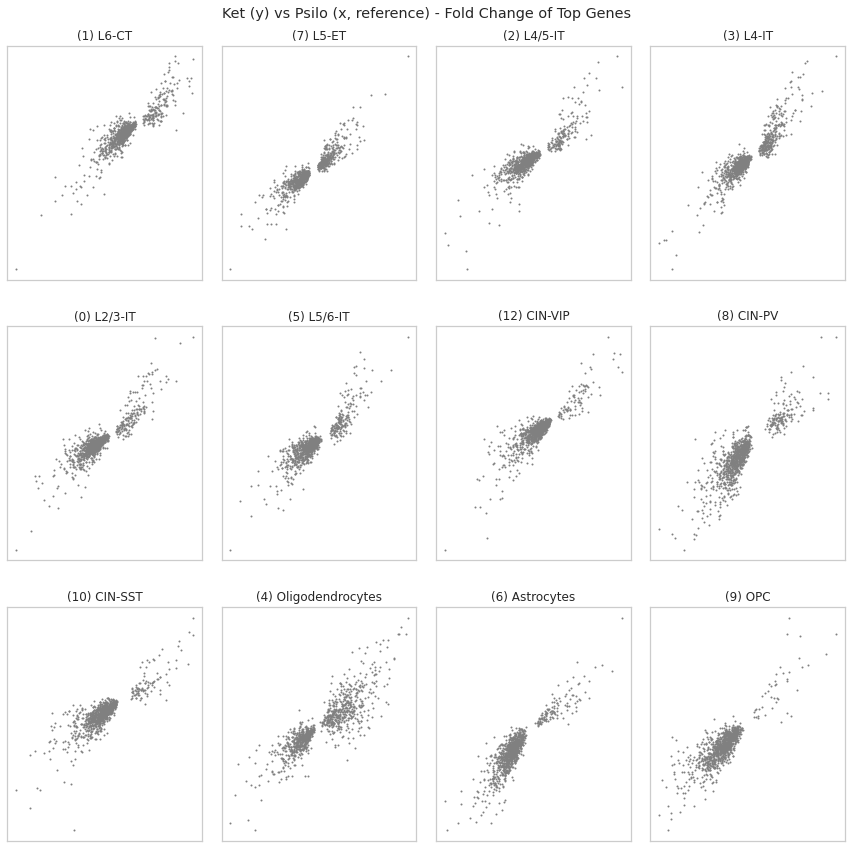

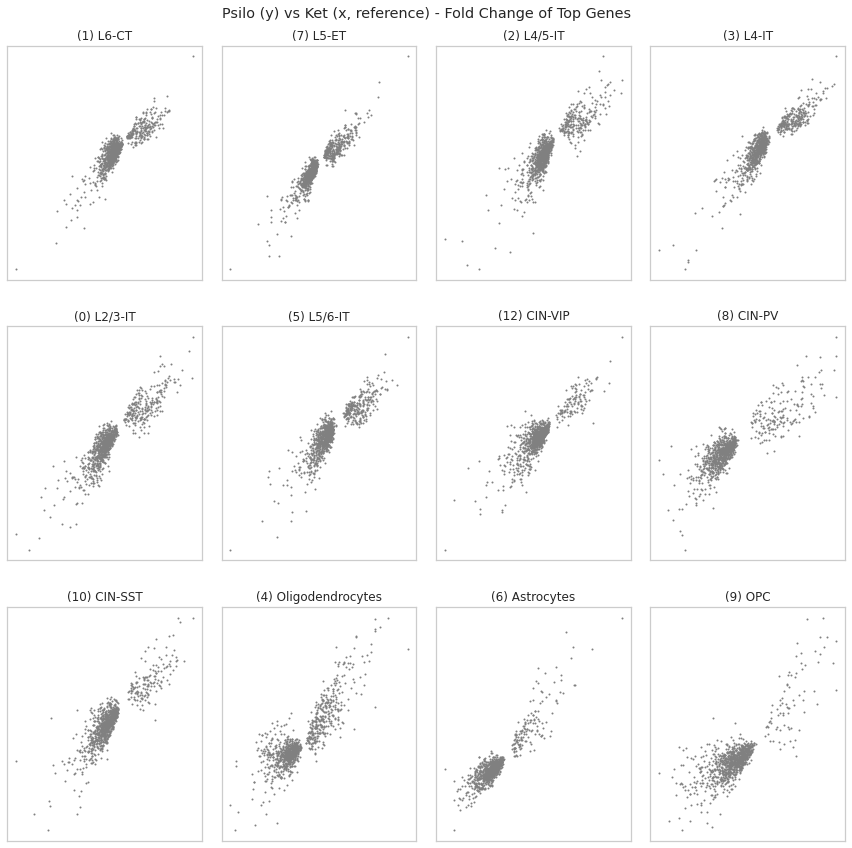

In [61]:
def interdrug_glyph_fc(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    square_grid_size = math.ceil(math.sqrt(len(heatmap_idx)))
    fig, axes = plt.subplots(math.ceil(len(heatmap_idx) / square_grid_size), square_grid_size, figsize=(12, 12))

    for i in range(len(heatmap_idx)):
        ax = axes[i // square_grid_size][i % square_grid_size]
        sns.scatterplot(
            data = swoosh_matrix_fc(drug_reference, heatmap_idx[i], drug_comparison, heatmap_idx[i]),
            x = 'home', y = 'away',
            color = 'grey',
            linewidth=0, s=4,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[], title=heatmap_cluster_labels[i])

    fig.suptitle(f'{drug_comparison} (y) vs {drug_reference} (x, reference) - Fold Change of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_interdrug_glyph_fc_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_interdrug_glyph_fc_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

interdrug_glyph_fc(['Psilo','Ket'])
interdrug_glyph_fc(['Ket','Psilo'])
pass

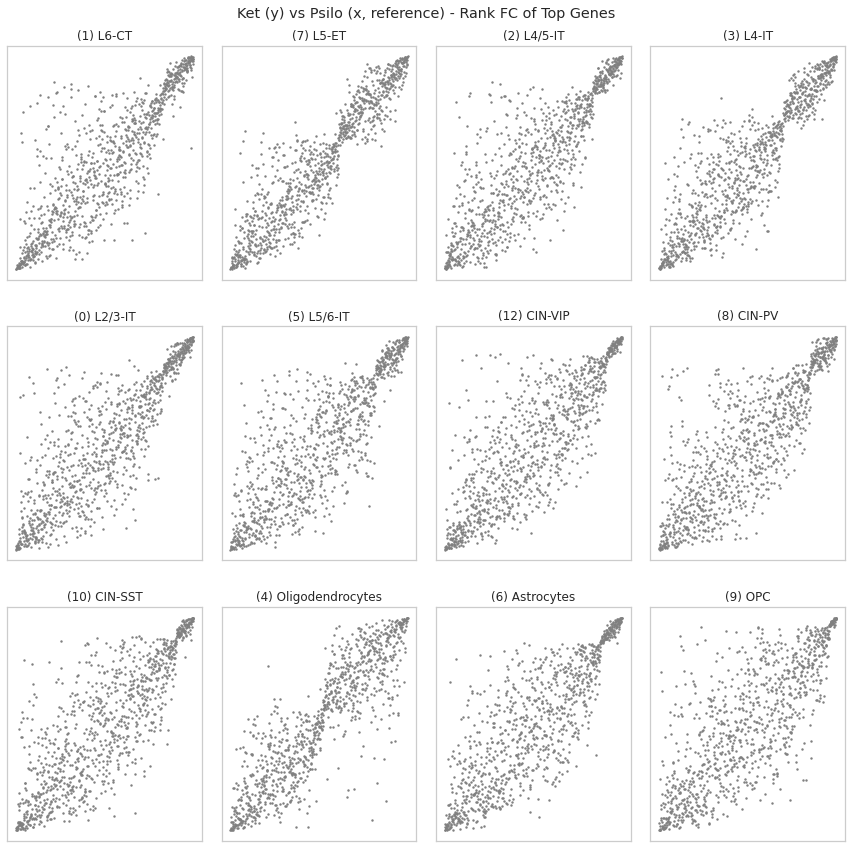

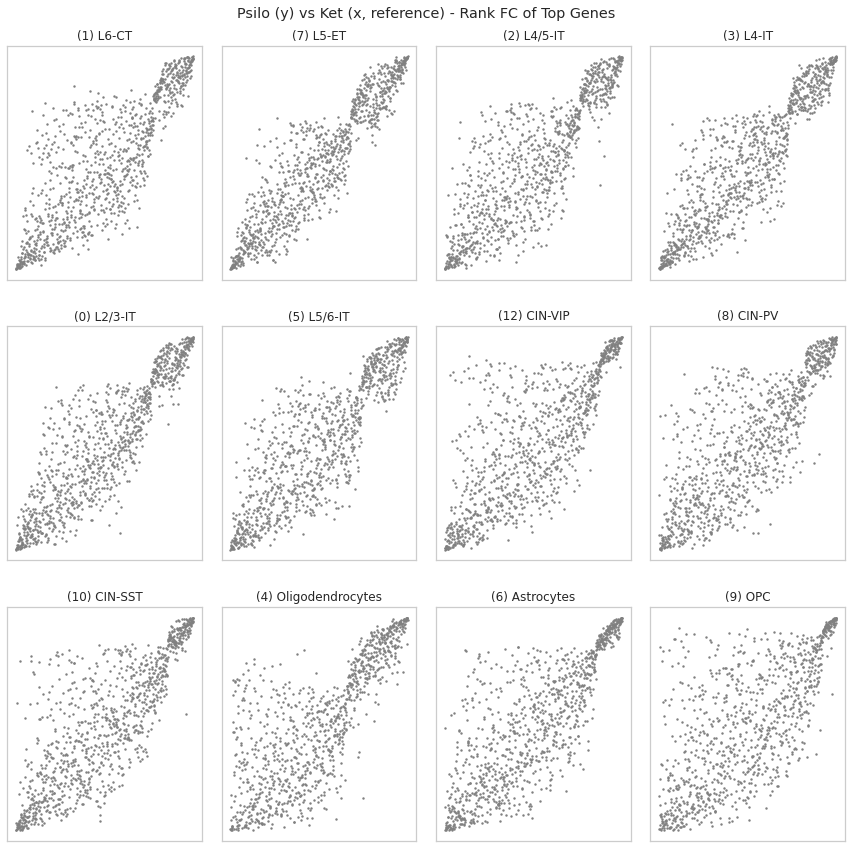

In [63]:
def interdrug_glyph_rank(drug_pairing):
    drug_reference, drug_comparison = drug_pairing
    heatmap_idx = cluster_lookup['name'].to_list()
    square_grid_size = math.ceil(math.sqrt(len(heatmap_idx)))
    fig, axes = plt.subplots(math.ceil(len(heatmap_idx) / square_grid_size), square_grid_size, figsize=(12, 12))

    for i in range(len(heatmap_idx)):
        ax = axes[i // square_grid_size][i % square_grid_size]
        sns.scatterplot(
            data = swoosh_matrix_rank(drug_reference, heatmap_idx[i], drug_comparison, heatmap_idx[i]),
            x = 'home', y = 'away',
            color = 'grey',
            linewidth=0, s=6,
            ax = ax
        )
        ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[], title=heatmap_cluster_labels[i])

    fig.suptitle(f'{drug_comparison} (y) vs {drug_reference} (x, reference) - Rank FC of Top Genes')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    fig.savefig(os.path.join(settings.fig_path, f'full_interdrug_glyph_rank_{drug_comparison}_vs_{drug_reference}.png'))
    fig.savefig(os.path.join(settings.fig_path, 'vectors', f'full_interdrug_glyph_rank_{drug_comparison}_vs_{drug_reference}.pdf'))
    return fig

interdrug_glyph_rank(['Psilo','Ket'])
interdrug_glyph_rank(['Ket','Psilo'])
pass